 #                                                    Instacart Online Grocery Market Basket Analytics

GitHub Link - https://github.com/J-Lehrer/aai_540_group_2_final_project/

## Importing necessary libraries

In [ ]:
import zipfile
import os
import pandas as pd

## Decompressing the "Archive" files.

In [ ]:
# Defining the path to the "Archives" folder.
archive_path = "/content/drive/MyDrive/MLOps/archive.zip"
extract_path ="/content/drive/MyDrive/MLOps/Instant_Cart"

# Extract the archive
with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(f"Files extracted to {extract_path}")

Files extracted to /content/drive/MyDrive/MLOps/Instant_Cart


### Loading the extracted CSV files

In [ ]:
extract_path ="/content/drive/MyDrive/MLOps/Instant_Cart"

In [ ]:
# Defining the paths to the files
orders_path = os.path.join(extract_path, 'orders.csv')
order_products_prior_path = os.path.join(extract_path, 'order_products__prior.csv')
order_products_train_path = os.path.join(extract_path, 'order_products__train.csv')
aisles_path = os.path.join(extract_path, 'aisles.csv')
departments_path = os.path.join(extract_path, 'departments.csv')
products_path = os.path.join(extract_path, 'products.csv')

# Loading the CSV files into DataFrames
orders = pd.read_csv(orders_path)
order_products_prior = pd.read_csv(order_products_prior_path)
order_products_train = pd.read_csv(order_products_train_path)
aisles = pd.read_csv(aisles_path)
departments = pd.read_csv(departments_path)
products = pd.read_csv(products_path)

print("Files successfully load!")

Files successfully load!


### Checking Dataframes

In [ ]:
# Checking DataFrame shape and info
print("Orders:")
print(orders.shape)
print(orders.info())
print("")
print("Order Products Prior:")
print(order_products_prior.shape)
print(order_products_prior.info())
print("")
print("Order Products Train:")
print(order_products_train.shape)
print(order_products_train.info())
print("")
print("Aisles:")
print(aisles.shape)
print(aisles.info())
print("")
print("Departments:")
print(departments.shape)
print(departments.info())
print("")
print("Products:")
print(products.shape)
print(products.info())


Orders:
(3421083, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB
None

Order Products Prior:
(32434489, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB
None

Order Products Train:
(1384617, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138

# Data Engineering

## Aggregate product orders

In this step, I am combining the dataset: order_products_prior.csv and order_products_train files to compute the total frequency of each product.

In [ ]:
# Combining prior and train datasets
all_order_products = pd.concat([order_products_prior, order_products_train])

# Calculating product frequency
product_frequency = all_order_products.groupby('product_id').size().reset_index(name='order_count')

# Getting the top 10,000 most ordered products
top_10k_products = product_frequency.nlargest(10000, 'order_count')
print("Top 10,000 products identified!")

Top 10,000 products identified!


## Filtering orders by Top 10,000 products

In this step, I am filtering the orders to include only those that contain one or more of the top 10,000 products

In [ ]:
# Filtering orders with top 10k products
filtered_orders = all_order_products[all_order_products['product_id'].isin(top_10k_products['product_id'])]

# Getting the list of relevant order IDs
filtered_order_ids = filtered_orders['order_id'].unique()

# Filtering the orders DataFrame
filtered_orders_df = orders[orders['order_id'].isin(filtered_order_ids)]
print(f"Filtered orders to include only top 10,000 products. Remaining orders: {len(filtered_orders_df)}")


Filtered orders to include only top 10,000 products. Remaining orders: 3321331


In [ ]:
print(filtered_orders_df.columns)

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')


## Further limiting orders by Size

In the previous step, the total number of orders were reduced to: 3,321,331. Next, I am further limiting the size by retaining orders with a minimum of (5) items to reduce the dataset size further.

In [ ]:
# Counting the number of items in each order
order_item_count = filtered_orders.groupby('order_id').size().reset_index(name='item_count')

# Setting the minimum item threshold (e.g., X = 5)
X = 5

# Filtering orders with at least X items
large_orders = order_item_count[order_item_count['item_count'] >= X]

# Getting the list of valid order IDs
valid_order_ids = large_orders['order_id']

# Filtering the original dataset to keep only the valid order IDs
filtered_orders_df = filtered_orders[filtered_orders['order_id'].isin(valid_order_ids)]

# Counting unique orders in the final filtered dataset
unique_orders_count = filtered_orders_df['order_id'].nunique()

print(f"Filtered down to orders with at least {X} items.")
print(f"Final number of unique orders: {unique_orders_count}")
print(f"Final number of rows (products): {len(filtered_orders_df)}")



Filtered down to orders with at least 5 items.
Final number of unique orders: 2400986
Final number of rows (products): 28368235


## Further limiting order to "Active Users"

Previously, I limited the orders to include only those that contain only 5 products from the top 10k products. We ended with a total size of: 2,400,986. For further reducing the dataset, I am going to focus on users with consistent purchasing behavior. For example, users with more than "Y" total orders. For accomplishing this step, I am going to count the total number of orders per user and filter users with at least 10 orders.

In [ ]:
print(filtered_orders_df.columns)


Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')


In [ ]:
# Merging user_id into filtered_orders_df
filtered_orders_df = pd.merge(
    filtered_orders_df,
    orders[['order_id', 'user_id']],
    on='order_id',
    how='left'
)

# Confirming the user_id column is now included
print(filtered_orders_df.columns)


Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id'], dtype='object')


In [ ]:
# Counting the total number of orders per user
user_order_counts = filtered_orders_df.groupby('user_id').size().reset_index(name='order_count')

# Setting the threshold for active users (e.g., Y = 10 orders)
Y = 10
active_users = user_order_counts[user_order_counts['order_count'] >= Y]
active_user_ids = active_users['user_id']

print(f"Number of active users with at least {Y} orders: {len(active_user_ids)}")


Number of active users with at least 10 orders: 184340


In [ ]:
filtered_orders_active_users = filtered_orders_df[filtered_orders_df['user_id'].isin(active_user_ids)]

print(f"Remaining orders: {len(filtered_orders_active_users)}")
print(f"Unique users: {filtered_orders_active_users['user_id'].nunique()}")


Remaining orders: 28313728
Unique users: 184340


In [ ]:
print(f"Unique orders remaining: {filtered_orders_active_users['order_id'].nunique()}")

Unique orders remaining: 2391917


In [ ]:
print(filtered_orders_active_users.columns)

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id'], dtype='object')


In [ ]:
# Saving filtered_orders_active_users DataFram into csv
filtered_orders_active_users.to_csv('/content/drive/MyDrive/MLOps/Instant_Cart/filtered_orders_active_users.csv', index=False)

## Further filtering by top 10 aisles or departments.

On the previous process, we obtained a total of 2,391,917 orders. This time, I am focusing on the most frequently ordered items within the top 10 departments. I will be identifying the top 10 departments with the highest number of orders for later retaining only the orders and products that belong to these top aisles or departments.

In [ ]:
filtered_orders_active_users = pd.read_csv('/content/drive/MyDrive/MLOps/Instant_Cart/filtered_orders_active_users.csv')

In the next step, I am merging aisles.csv and departments.csv with products.csv to enrich the product information with aisle and department details.

In [ ]:
# Merging products with aisles and departments
products_enriched = pd.merge(
    products,
    aisles,
    on='aisle_id',
    how='left'
)
products_enriched = pd.merge(
    products_enriched,
    departments,
    on='department_id',
    how='left'
)

# Verifying the columns in the enriched product dataset
print(products_enriched.columns)


Index(['product_id', 'product_name', 'aisle_id', 'department_id', 'aisle',
       'department'],
      dtype='object')


Below, I joing the enriched products information (products_enriched) with the (filtered_orders_active_users) DataFrame.

In [ ]:
# Merging product details into the filtered orders dataset
filtered_orders_with_details = pd.merge(
    filtered_orders_active_users,
    products_enriched,
    on='product_id',
    how='left'
)

# Verifying the merged dataset
print(filtered_orders_with_details.columns)


Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'product_name', 'aisle_id', 'department_id', 'aisle', 'department'],
      dtype='object')


Next, I group the data by aisle and department (separate) and calculate the total number of orders. Then, sorting the results in descending order and retain the top 10.

In [ ]:
# Counting orders by aisle
aisle_order_counts = filtered_orders_with_details.groupby('aisle').size().reset_index(name='order_count')

# Getting the top 10 aisles
top_aisles = aisle_order_counts.nlargest(10, 'order_count')
top_aisle_names = top_aisles['aisle']

print(f"Top 10 aisles: {list(top_aisle_names)}")


Top 10 aisles: ['fresh fruits', 'fresh vegetables', 'packaged vegetables fruits', 'yogurt', 'packaged cheese', 'milk', 'water seltzer sparkling water', 'chips pretzels', 'soy lactosefree', 'bread']


In [ ]:
# Counting orders by department
department_order_counts = filtered_orders_with_details.groupby('department').size().reset_index(name='order_count')

# Getting the top 10 departments
top_departments = department_order_counts.nlargest(10, 'order_count')
top_department_names = top_departments['department']

print(f"Top 10 departments: {list(top_department_names)}")


Top 10 departments: ['produce', 'dairy eggs', 'snacks', 'beverages', 'frozen', 'pantry', 'bakery', 'deli', 'canned goods', 'dry goods pasta']


In [ ]:
# Filtering orders for top aisles
filtered_by_aisles = filtered_orders_with_details[filtered_orders_with_details['aisle'].isin(top_aisle_names)]

print(f"Remaining orders after filtering by top aisles: {len(filtered_by_aisles)}")


Remaining orders after filtering by top aisles: 14096649


In [ ]:
# Filtering orders for top departments
filtered_by_departments = filtered_orders_with_details[filtered_orders_with_details['department'].isin(top_department_names)]

print(f"Remaining orders after filtering by top departments: {len(filtered_by_departments)}")


Remaining orders after filtering by top departments: 25702383


In [ ]:
# Verifying aisles or departments in the filtered dataset
print(filtered_by_aisles['aisle'].value_counts())
print(filtered_by_departments['department'].value_counts())


aisle
fresh fruits                     3485989
fresh vegetables                 3378122
packaged vegetables fruits       1686448
yogurt                           1364214
packaged cheese                   905963
milk                              806036
water seltzer sparkling water     720034
chips pretzels                    635021
soy lactosefree                   587908
bread                             526914
Name: count, dtype: int64
department
produce            9133122
dairy eggs         4988600
snacks             2366457
beverages          2168493
frozen             1888991
pantry             1502823
bakery             1042682
deli                940087
canned goods        928885
dry goods pasta     742243
Name: count, dtype: int64


I decided to filter the data by "Top 10 Departments" for the following reasons:

- It aligns with the project's goal of creatinga resuable ML pipeline, as department-level insights generalize better.
- Provides a broader perspective, covering diverse products and trends.
- Reduces the dataset size efficiently while retaining valuable data for high-level analysis.

Next, I filter the dataset by the top 10 departments: produce, dairy eggs, snacks, etc. Then, I save the filtered dataset into .csv format.

In [ ]:
import pandas as pd

# Paths to the files
output_path = "/content/drive/MyDrive/MLOps/Instant_Cart/filtered_by_top_departments.csv"  # Desired output path

# Top 10 departments
top_departments = [
    "produce", "dairy eggs", "snacks", "beverages", "frozen",
    "pantry", "bakery", "deli", "canned goods", "dry goods pasta"
]

# Filtering the dataset to include only top departments
filtered_by_departments = filtered_orders_with_details[
    filtered_orders_with_details['department'].isin(top_departments)
]

# Saving the filtered dataset
filtered_by_departments.to_csv(output_path, index=False)

# Summary of the filtered dataset
filtered_summary = {
    "Remaining Rows": len(filtered_by_departments),
    "Unique Orders": filtered_by_departments['order_id'].nunique(),
    "Unique Users": filtered_by_departments['user_id'].nunique(),
    "Unique Departments": filtered_by_departments['department'].nunique()
}

print("Filtered dataset saved successfully.")
print(filtered_summary)


Filtered dataset saved successfully.
{'Remaining Rows': 25702383, 'Unique Orders': 2389985, 'Unique Users': 184304, 'Unique Departments': 10}


## Further filtering rarely reordered products





From the previous filtering process, we obtained a total number of unique orders of: 2,389,985. Now, I will proceed to calculate the reorder rate for each product by grouping the data by product_id and taking the mean of the "reordered" column.

In [ ]:
import pandas as pd

# Loading the filtered dataset
filtered_by_top_departments_path = "/content/drive/MyDrive/MLOps/Instant_Cart/filtered_by_top_departments.csv"
filtered_by_top_departments = pd.read_csv(filtered_by_top_departments_path)

# Calculating reorder rate for each product
product_reorder_rate = filtered_by_top_departments.groupby('product_id')['reordered'].mean().reset_index()
product_reorder_rate.rename(columns={'reordered': 'reorder_rate'}, inplace=True)

# Setting a threshold for rarely reordered products (e.g., 0.2 or 20%)
threshold = 0.2
frequently_reordered_products = product_reorder_rate[product_reorder_rate['reorder_rate'] > threshold]

print(f"Products with a reorder rate above {threshold}: {len(frequently_reordered_products)}")


Products with a reorder rate above 0.2: 8002


In [ ]:
# Filtering the dataset to include only frequently reordered products
filtered_frequent_reorders = filtered_by_top_departments[
    filtered_by_top_departments['product_id'].isin(frequently_reordered_products['product_id'])
]

print(f"Filtered dataset to include frequently reordered products.")
print(f"Remaining Rows: {len(filtered_frequent_reorders)}")
print(f"Unique Orders: {filtered_frequent_reorders['order_id'].nunique()}")
print(f"Unique Products: {filtered_frequent_reorders['product_id'].nunique()}")


Filtered dataset to include frequently reordered products.
Remaining Rows: 25454061
Unique Orders: 2389931
Unique Products: 8002


In [ ]:
# Saving the filtered dataset
output_path_frequent_reorders = "/content/drive/MyDrive/MLOps/Instant_Cart/filtered_frequent_reorders.csv"
filtered_frequent_reorders.to_csv(output_path_frequent_reorders, index=False)

print(f"Filtered dataset saved at {output_path_frequent_reorders}.")


Filtered dataset saved at /content/drive/MyDrive/MLOps/Instant_Cart/filtered_frequent_reorders.csv.


## Filtering for frequent buyer

From the previous result, the dataset was only reduced to: 2,389,931 orders. Next, I am filtering by identifying frequent buyey. For example: retain users who order top products at least N times.

## N = 450.
This first dataset will be balanced between most frequent buyers and non active users.

**Note to consider:**

As we increase "N", the focus is only on the most active users, which may bias the model toward frequent buyes and their behavior.

The model might become less generalize to users with lower purchasing activity.

If the dataset is heavily skewed toward a small group of active users, some product-specific might be lost. However, keeping more frequent buyers might still capture sufficient trends highly reordered products.

A piperline trained on a subset of frequent buyers may perform for similr groups but may not generalize to less frequent users or broader audience.

In [ ]:
# Defining the threshold for frequent buyers (e.g., at least N = 10 orders)
N = 450

# Counting the number of orders per user
user_order_counts = filtered_frequent_reorders.groupby('user_id').size().reset_index(name='order_count')

# Filtering users with at least N orders
frequent_buyers = user_order_counts[user_order_counts['order_count'] >= N]
frequent_buyer_ids = frequent_buyers['user_id']

print(f"Number of frequent buyers with at least {N} orders: {len(frequent_buyer_ids)}")


Number of frequent buyers with at least 450 orders: 11033


In [ ]:
# Filtering orders for frequent buyers
filtered_frequent_buyers = filtered_frequent_reorders[
    filtered_frequent_reorders['user_id'].isin(frequent_buyer_ids)
]

print(f"Filtered dataset to include orders from frequent buyers.")
print(f"Remaining Rows: {len(filtered_frequent_buyers)}")
print(f"Unique Orders: {filtered_frequent_buyers['order_id'].nunique()}")
print(f"Unique Users: {filtered_frequent_buyers['user_id'].nunique()}")


Filtered dataset to include orders from frequent buyers.
Remaining Rows: 7588145
Unique Orders: 562019
Unique Users: 11033


In [ ]:
# Saving the filtered dataset
output_path_frequent_buyers = "/content/drive/MyDrive/MLOps/Instant_Cart/filtered_frequent_buyers_v1.csv"
filtered_frequent_buyers.to_csv(output_path_frequent_buyers, index=False)

print(f"Filtered dataset saved at {output_path_frequent_buyers}.")


Filtered dataset saved at /content/drive/MyDrive/MLOps/Instant_Cart/filtered_frequent_buyers_v1.csv.


## N = 850

This dataset will be for the less generalize ML model.

In [ ]:
N = 850

# Counting the number of orders per user
user_order_counts = filtered_frequent_reorders.groupby('user_id').size().reset_index(name='order_count')

# Filtering users with at least N orders
frequent_buyers = user_order_counts[user_order_counts['order_count'] >= N]
frequent_buyer_ids = frequent_buyers['user_id']

print(f"Number of frequent buyers with at least {N} orders: {len(frequent_buyer_ids)}")

Number of frequent buyers with at least 850 orders: 2081


In [ ]:
# Filtering orders for frequent buyers
filtered_frequent_buyers = filtered_frequent_reorders[
    filtered_frequent_reorders['user_id'].isin(frequent_buyer_ids)
]

print(f"Filtered dataset to include orders from frequent buyers.")
print(f"Remaining Rows: {len(filtered_frequent_buyers)}")
print(f"Unique Orders: {filtered_frequent_buyers['order_id'].nunique()}")
print(f"Unique Users: {filtered_frequent_buyers['user_id'].nunique()}")


Filtered dataset to include orders from frequent buyers.
Remaining Rows: 2253205
Unique Orders: 137382
Unique Users: 2081


In [ ]:
# Saving the filtered dataset
output_path_frequent_buyers = "/content/drive/MyDrive/MLOps/Instant_Cart/filtered_frequent_buyers_v2.csv"
filtered_frequent_buyers.to_csv(output_path_frequent_buyers, index=False)

print(f"Filtered dataset saved at {output_path_frequent_buyers}.")


Filtered dataset saved at /content/drive/MyDrive/MLOps/Instant_Cart/filtered_frequent_buyers_v2.csv.


# Exploratory Data Analysis

### Installing necessary libraries

In [ ]:
! pip install pyathena
!pip install awswrangler
!pip install seaborn
!pip install --upgrade s3fs aiobotocore botocore
import s3fs
import botocore

print(f"s3fs version: {s3fs.__version__}")
print(f"botocore version: {botocore.__version__}")
from pyathena import connect
import awswrangler as wr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Converting InstantCart CSV dataset into Parquet

In [ ]:
csv_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/filtered_frequent_buyers_v1.csv"
df = pd.read_csv(csv_path)
# Loading CSV from S3

train_df, remaining_df = train_test_split(df, train_size=0.4, random_state=42)

# Split the remaining data into production and temp datasets (66% production, 33% temp)
production_df, temp_df = train_test_split(remaining_df, train_size=0.666666, random_state=42)

# Split the temp data into test and validation datasets (50% test, 50% validation)
test_df, validation_df = train_test_split(temp_df, train_size=0.5, random_state=42)

In [ ]:
# Defining S3 paths
parquet_output_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/"


# Save each split dataset to Parquet with partitioning by 'department'
wr.s3.to_parquet(
    df=train_df,
    path=parquet_output_path + "train/",
    dataset=True,
    mode="overwrite",
    partition_cols=["department"],
    compression="snappy"
)

wr.s3.to_parquet(
    df=production_df,
    path=parquet_output_path + "production/",
    dataset=True,
    mode="overwrite",
    partition_cols=["department"],
    compression="snappy"
)

wr.s3.to_parquet(
    df=test_df,
    path=parquet_output_path + "test/",
    dataset=True,
    mode="overwrite",
    partition_cols=["department"],
    compression="snappy"
)

wr.s3.to_parquet(
    df=validation_df,
    path=parquet_output_path + "validation/",
    dataset=True,
    mode="overwrite",
    partition_cols=["department"],
    compression="snappy"
)




{'paths': ['s3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/validation/department=bakery/d4c662bd11ec4e36a6d97eba6ff50b1a.snappy.parquet',
  's3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/validation/department=beverages/d4c662bd11ec4e36a6d97eba6ff50b1a.snappy.parquet',
  's3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/validation/department=canned goods/d4c662bd11ec4e36a6d97eba6ff50b1a.snappy.parquet',
  's3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/validation/department=dairy eggs/d4c662bd11ec4e36a6d97eba6ff50b1a.snappy.parquet',
  's3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/validation/department=deli/d4c662bd11ec4e36a6d97eba6ff50b1a.snappy.parquet',
  's3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/validation/department=dry goods pasta/d4c662bd11ec4e36a6d97eba6ff50b1a.snappy.parquet',
  's3://sagemaker-us-east-1-9219168

In [ ]:
# Create the database if it doesn't exist
database_name = "instacart_db_split"
try:
    # Create the database in AWS Glue
    wr.catalog.create_database(name=database_name)
    print(f"Database '{database_name}' created successfully!")
except Exception as e:
    print(f"Error creating database: {e}")

Database 'instacart_db_split' created successfully!


In [ ]:
# Register the Parquet tables in AWS Glue
table_name = "instacart_orders"

wr.catalog.create_parquet_table(
    database=database_name,
    table=table_name,
    path=parquet_output_path + "train/",
    columns_types={
        "order_id": "bigint",
        "product_id": "bigint",
        "add_to_cart_order": "int",
        "reordered": "int",
        "user_id": "bigint",
        "product_name": "string",
        "aisle_id": "int",
        "department_id": "int",
        "aisle": "string",
        "department": "string"
    },
    partitions_types={"department": "string"},
    description="Partitioned Instacart orders dataset for optimized Athena queries."
)

print("Partitioned Parquet table registered in AWS Glue successfully.")


Partitioned Parquet table registered in AWS Glue successfully.


## Setting up Database for InstantCart

In [ ]:
from pyathena import connect

# Defineing AWS Resources
bucket_name = "sagemaker-us-east-1-921916832724"
region = "us-east-1"
database_name = "instacart_db_split"
table_name = "instacart_orders"
s3_data_location = f"s3://{bucket_name}/data-lake/Project/partitioned_split/train/"  # Using partitioned dataset

# Defining Athena Staging Directory
s3_staging_dir = f"s3://{bucket_name}/athena/instacart_staging_split/"

# Creating Athena Connection
try:
    conn = connect(s3_staging_dir=s3_staging_dir, region_name=region)
    cursor = conn.cursor()
    print("Connected to Athena successfully.")
except Exception as e:
    print("Error connecting to Athena:", e)

# Creating Database
create_db_query = f"CREATE DATABASE IF NOT EXISTS {database_name}"
cursor.execute(create_db_query)
print(f"Database '{database_name}' created successfully!")

# Verifying Database Creation
cursor.execute("SHOW DATABASES")
databases = [row[0] for row in cursor.fetchall()]
if database_name in databases:
    print(f"Database '{database_name}' exists!")


Connected to Athena successfully.
Database 'instacart_db_split' created successfully!
Database 'instacart_db_split' exists!


## Creating Athena database

In [ ]:
# Define the SQL query to create the table
create_table_query = """
CREATE EXTERNAL TABLE IF NOT EXISTS instacart_db_split.instacart_orders (
    order_id BIGINT,
    product_id BIGINT,
    add_to_cart_order INT,
    reordered INT,
    user_id BIGINT,
    product_name STRING,
    aisle_id INT,
    department_id INT,
    aisle STRING
)
PARTITIONED BY (department STRING)  -- Partitioned by department
STORED AS PARQUET
LOCATION 's3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/train/'  
TBLPROPERTIES ('parquet.compression'='SNAPPY');
"""

# Execute the SQL query in Athena
cursor.execute(create_table_query)
print("Table 'instacart_orders' created successfully in database 'instacart_db_split'.")



Table 'instacart_orders' created successfully in database 'instacart_db_split'.


In [ ]:

# Running MSCK REPAIR to Load Partitions
cursor.execute(f"MSCK REPAIR TABLE {database_name}.{table_name}")
print("Partitions updated successfully.")

Partitions updated successfully.


In [ ]:
cursor.execute("SHOW DATABASES")
databases = [row[0] for row in cursor.fetchall()]
if database_name in databases:
    print(f"Database '{database_name}' exists in Athena!")
else:
    print(f"Database '{database_name}' does not exist.")


Database 'instacart_db_split' exists in Athena!


In [ ]:
import boto3

s3 = boto3.client('s3')
response = s3.list_objects_v2(Bucket='sagemaker-us-east-1-921916832724', Prefix='data-lake/Project/partitioned_split/train/')
for obj in response.get('Contents', []):
    print(obj['Key'])


data-lake/Project/partitioned_split/train/department=bakery/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-lake/Project/partitioned_split/train/department=beverages/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-lake/Project/partitioned_split/train/department=canned goods/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-lake/Project/partitioned_split/train/department=dairy eggs/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-lake/Project/partitioned_split/train/department=deli/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-lake/Project/partitioned_split/train/department=dry goods pasta/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-lake/Project/partitioned_split/train/department=frozen/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-lake/Project/partitioned_split/train/department=pantry/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-lake/Project/partitioned_split/train/department=produce/934698bd96d5445dbb1a737f5a354225.snappy.parquet
data-la

In [ ]:
# Running a Sample Query to Verify Data
test_query = f"SELECT count(*) FROM {database_name}.{table_name} ;"
cursor.execute(test_query)
rows = cursor.fetchall()

print("Sample Query Results:")
for row in rows:
    print(row)

Sample Query Results:
(3035258,)


In [ ]:
cursor.execute(f"SHOW PARTITIONS {database_name}.{table_name}")
partitions = cursor.fetchall()
if partitions:
    print(f"Partitions found in table '{table_name}': {partitions}")
else:
    print(f"No partitions found in table '{table_name}'.")


Partitions found in table 'instacart_orders': [('department=produce',), ('department=dairy eggs',), ('department=snacks',), ('department=deli',), ('department=frozen',), ('department=pantry',), ('department=beverages',), ('department=canned goods',), ('department=bakery',), ('department=dry goods pasta',)]


## EDA in the training set

### Checking the Total Orders and Unique Users

In [ ]:

# First Query: Total Orders & Unique Users
query = f"""
SELECT
    COUNT(DISTINCT order_id) AS total_orders,
    COUNT(DISTINCT user_id) AS unique_users
FROM {database_name}.{table_name};
"""

# Executing query
cursor.execute(query)
rows = cursor.fetchall()

# Printing results
print("Total Orders & Unique Users:")
for row in rows:
    print(row)


Total Orders & Unique Users:
(552593, 11033)


### Top 10 Most Ordered Products


In [ ]:
query = f"""
SELECT product_name, COUNT(*) AS total_orders
FROM {database_name}.{table_name}
GROUP BY product_name
ORDER BY total_orders DESC
LIMIT 10;
"""
cursor.execute(query)
rows = cursor.fetchall()
print("Top 10 Most Ordered Products:")
for row in rows:
    print(row)


Top 10 Most Ordered Products:
('Banana', 52073)
('Bag of Organic Bananas', 46964)
('Organic Strawberries', 39311)
('Organic Hass Avocado', 31555)
('Organic Baby Spinach', 29459)
('Organic Raspberries', 21479)
('Organic Avocado', 19582)
('Organic Whole Milk', 19211)
('Limes', 17136)
('Large Lemon', 16719)


/tmp/ipykernel_234/1557864825.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Total Orders", y="Product Name", data=df_products, palette="viridis")


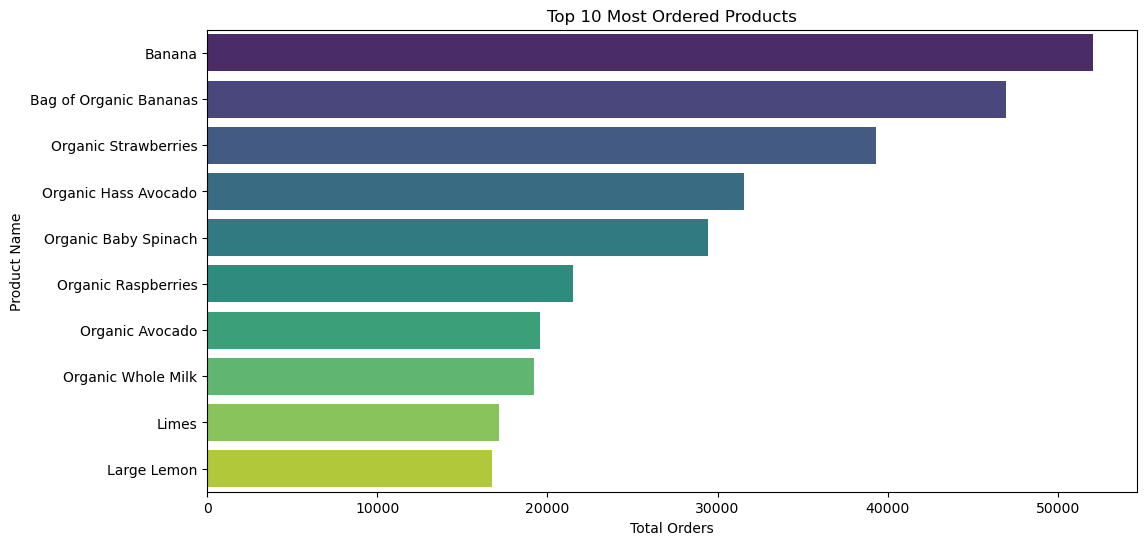

In [ ]:
# ===========================
#  Bar Chart: Top 10 Most Ordered Products
# ===========================

products = ["Banana", "Bag of Organic Bananas", "Organic Strawberries", "Organic Hass Avocado",
            "Organic Baby Spinach", "Organic Raspberries", "Organic Avocado", "Organic Whole Milk",
            "Limes", "Large Lemon"]
total_orders = [52073, 46964, 39311, 31555, 29459, 21479, 19582, 19211, 17136, 16719]

# Creating DataFrame
df_products = pd.DataFrame({"Product Name": products, "Total Orders": total_orders})

# Plotting Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x="Total Orders", y="Product Name", data=df_products, palette="viridis")
plt.xlabel("Total Orders")
plt.ylabel("Product Name")
plt.title("Top 10 Most Ordered Products")
plt.show()


### Insights

- Bananas are the most ordered item with 52073 orders.
- Organic produce is extremely popular. Where 7 out of 10 items are organic.
- Dairy products like Whole Milk rank in the Top 10.
- Cirtrus fruits like Limes and Lemons are in high demand.

### Reorder Rate per Product

In [ ]:
query = f"""
SELECT
    product_name,
    COUNT(*) AS total_orders,
    SUM(reordered) AS total_reorders,
    ROUND(100.0 * SUM(reordered) / COUNT(*), 2) AS reorder_rate
FROM {database_name}.{table_name}
GROUP BY product_name
ORDER BY reorder_rate DESC
LIMIT 10;
"""
cursor.execute(query)
rows = cursor.fetchall()
print("Top 10 Products with Highest Reorder Rate:")
for row in rows:
    print(row)


Top 10 Products with Highest Reorder Rate:
('Salted Sweet Cream Butter Quarters', 1, 1, 100.0)
('Green Bananas', 3, 3, 100.0)
('Premium Lots of Pulp Orange Juice', 6, 6, 100.0)
('Sparkling Water, Bottles', 3, 3, 100.0)
('100% Lactose Free Milk', 6, 6, 100.0)
('Peru Sweet Onions', 2, 2, 100.0)
('Smoked Whitefish Salad', 33, 33, 100.0)
('Seltzer Water', 15, 15, 100.0)
('Thirst Quencher Caffeine Free Naturally Flavored Citrus Soda', 28, 28, 100.0)
('Classic Baby Creamers Potatoes', 7, 7, 100.0)


### Insights for Top 10 Products with Highest Reorder Rate:

- **100% Lactose-Free Milk** has a **100% reorder rate**, indicating it is a highly demanded product among lactose-intolerant customers who consistently reorder it.
- **Salted Sweet Cream Butter Quarters**, **Sparkling Water Bottles**, and **Premium Lots of Pulp Orange Juice** also show a **100% reorder rate**, signifying that these are popular products with strong customer loyalty and recurring demand.
- **Classic Baby Creamers Potatoes** and **Peru Sweet Onions** are products with **100% reorder rate**, pointing to their continued preference and high re-purchase frequency among customers.
- **Thirst Quencher Caffeine-Free Naturally Flavored Citrus Soda** and **Smoked Whitefish Salad** reflect **100% reorder rates**, highlighting that these items are consistently chosen by customers who keep coming back for more.
- **Seltzer Water** and **Green Bananas** demonstrate high reorder demand, each maintaining **100% reorder rate**, suggesting these are staple items that customers rely on regularly.

### Orders by Department

In [ ]:
query = f"""
SELECT department, COUNT(*) AS total_orders
FROM {database_name}.{table_name}
GROUP BY department
ORDER BY total_orders DESC;
"""
cursor.execute(query)
rows = cursor.fetchall()
print("Orders by Department:")
for row in rows:
    print(row)


Orders by Department:
('produce', 1116850)
('dairy eggs', 619999)
('snacks', 294213)
('beverages', 234613)
('frozen', 201359)
('pantry', 138924)
('bakery', 127884)
('deli', 114349)
('canned goods', 102416)
('dry goods pasta', 84651)


/tmp/ipykernel_234/1099213901.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Total Orders", y="Department", data=df_orders_by_department, palette="magma")


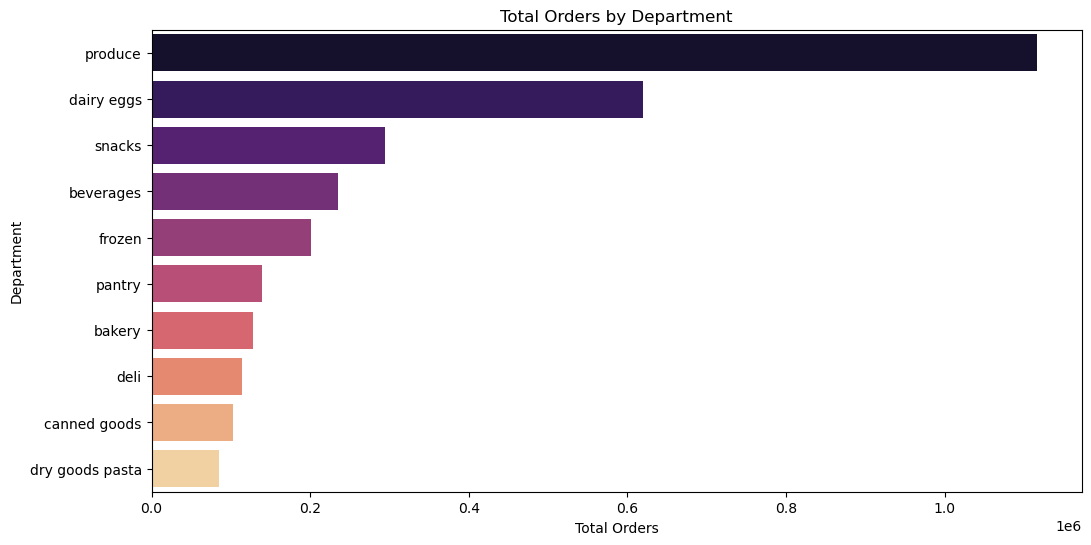

In [ ]:
# ===========================
# Bar Chart: Orders by Department
# ===========================

# Data from previous query (Department, Total Orders)
departments = ["produce", "dairy eggs", "snacks", "beverages", "frozen",
               "pantry", "bakery", "deli", "canned goods", "dry goods pasta"]
total_orders = [1116850, 619999, 294213, 234613, 201359, 138924, 127884, 114349, 102416, 84651]

# Creating DataFrame
df_orders_by_department = pd.DataFrame({"Department": departments, "Total Orders": total_orders})

# Plotting Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x="Total Orders", y="Department", data=df_orders_by_department, palette="magma")
plt.xlabel("Total Orders")
plt.ylabel("Department")
plt.title("Total Orders by Department")
plt.show()


### Insights

- Produce is the most ordered department with ~1.11 million orders. This aligns with the earlier Top Ordered Products (bananas, avocados, berries). On another hand, Fresh produce is frequently bought and likely reordered often.
- Dairy & Eggs ranks second with 619K orders.
- Snacks are the third most popular category (294K orders).
    - Expect chips, granola bars, and nuts to dominate.
- Beverages & Frozen Foods also have strong demand.
    - Beverages (~234K orders) likely include popular items like bottled water, juices, and coffee.
    - Frozen Foods (~201K orders) suggest customers stock up on frozen essentials.
- Pantry Staples, Bakery, and Deli also contribute significantly. It could likely contain bread, canned goods, and dry pasta.

### Most Popular Aisles

In [ ]:
query = f"""
SELECT aisle, COUNT(*) AS total_orders
FROM {database_name}.{table_name}
GROUP BY aisle
ORDER BY total_orders DESC
LIMIT 10;
"""
cursor.execute(query)
rows = cursor.fetchall()
print("Top 10 Aisles:")
for row in rows:
    print(row)


Top 10 Aisles:
('fresh fruits', 450026)
('fresh vegetables', 404252)
('packaged vegetables fruits', 205492)
('yogurt', 184903)
('packaged cheese', 112690)
('milk', 103953)
('water seltzer sparkling water', 78019)
('chips pretzels', 74536)
('soy lactosefree', 68786)
('bread', 65469)


/tmp/ipykernel_234/4010282009.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Total Orders", y="Aisle", data=df_aisles, palette="coolwarm")


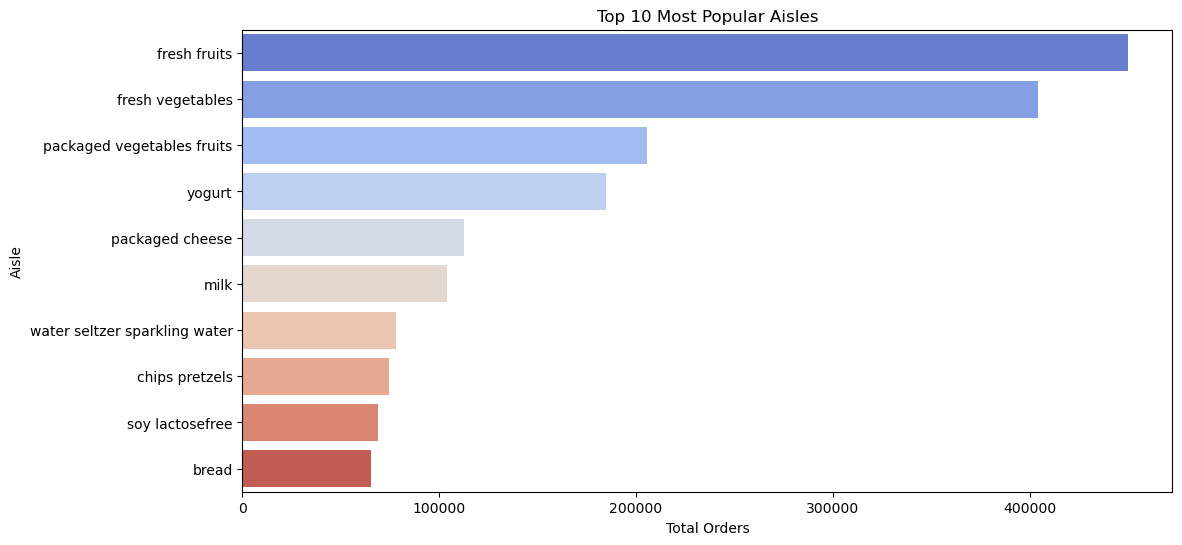

In [ ]:
# ===========================
# Bar Chart: Most Popular Aisles
# ===========================

# Data from previous query (Aisle, Total Orders)
aisles = ["fresh fruits", "fresh vegetables", "packaged vegetables fruits", "yogurt",
          "packaged cheese", "milk", "water seltzer sparkling water", "chips pretzels",
          "soy lactosefree", "bread"]
aisle_orders = [450026, 404252, 205492, 184903, 112690, 103953, 78019, 74536, 68786, 65469]

# Creating DataFrame
df_aisles = pd.DataFrame({"Aisle": aisles, "Total Orders": aisle_orders})

# Plotting Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x="Total Orders", y="Aisle", data=df_aisles, palette="coolwarm")
plt.xlabel("Total Orders")
plt.ylabel("Aisle")
plt.title("Top 10 Most Popular Aisles")
plt.show()

### Insights
- Fresh Produce Dominance:
    - Fresh Fruits (450K orders) and Fresh Vegetables (404K orders) are the top two aisles.
    - Combined, these two alone account for over 950K orders, which reinforces why Produce is the top department.

- Dairy is Highly Popular:
    - Yogurt (184K orders) and Packaged Cheese (112K orders) show strong demand.
    - Milk (103K orders) further confirms that dairy products are household essentials.

- Beverages are a Major Category:
    - Water, Seltzer, and Sparkling Water (78K orders) ranks #7, showing strong demand for bottled drinks.

- Snacks & Bread are Key Pantry Items
    - Chips & Pretzels (74K orders) are among the most frequently purchased snacks.
    - Bread (65K orders) confirms why Bakery is among the top departments.

- Plant-Based Alternatives are Growing
    - Soy & Lactose-Free Products (68K orders) indicate increased demand for dairy-free alternatives.

###  Reorder Ratio by Department

In [ ]:
query = f"""
SELECT
    department,
    COUNT(*) AS total_orders,
    SUM(reordered) AS total_reorders,
    ROUND(100.0 * SUM(reordered) / COUNT(*), 2) AS reorder_ratio
FROM {database_name}.{table_name}
GROUP BY department
ORDER BY reorder_ratio DESC;
"""
cursor.execute(query)
rows = cursor.fetchall()
print("Reorder Ratio by Department:")
for row in rows:
    print(row)


Reorder Ratio by Department:
('dairy eggs', 619999, 512956, 82.73)
('beverages', 234613, 189692, 80.85)
('produce', 1116850, 901358, 80.71)
('bakery', 127884, 102853, 80.43)
('deli', 114349, 89802, 78.53)
('snacks', 294213, 217758, 74.01)
('frozen', 201359, 144719, 71.87)
('canned goods', 102416, 67094, 65.51)
('dry goods pasta', 84651, 55299, 65.33)
('pantry', 138924, 79541, 57.26)


### Insights

- Dairy & Eggs Have the Highest Reorder Rate (82.73%)
    - Most frequently reordered category.
    - Milk, Yogurt, and Cheese are household staples → high repurchase behavior.

- Beverages Rank #2 in Reorders (80.85%)
    - Bottled Water, Sparkling Water, and Coffee/Tea are commonly repurchased.
    - These items are frequently consumed & replaced regularly.

- Produce Has a High Reorder Rate (80.71%)
    - Fruits and vegetables have a high purchase frequency.
    - Bananas, Avocados, and Berries from previous queries reinforce this trend.

- Bakery (80.43%) & Deli (78.53%) Show Strong Reorder Loyalty
    - Bread, Bagels, and Pre-packaged Deli Items are regularly bought items.
    - Customers often stick to the same brands.

- Snacks & Frozen Foods Have Moderate Reorder Rates (~70%)
    - Chips, Pretzels, and Frozen Meals are repurchased but less frequently than fresh foods.

- Canned Goods & Dry Goods Have Lower Reorder Rates (~65%)
    - Longer shelf life → not purchased as frequently.

- Pasta, sauces, and canned vegetables last longer → lower immediate repurchase need.

- Pantry Has the Lowest Reorder Rate (57.26%)
    - Less frequent purchases of pantry staples like flour, condiments, and spices.

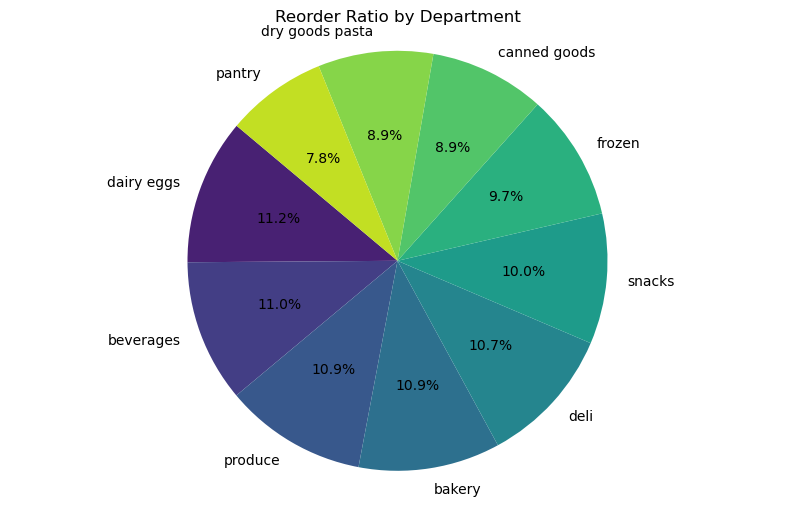

In [ ]:
# ===========================
# Pie Chart: Reorder Ratio by Department
# ===========================

# Data from previous query (Department, Reorder Ratio)
departments = ["dairy eggs", "beverages", "produce", "bakery", "deli",
               "snacks", "frozen", "canned goods", "dry goods pasta", "pantry"]
reorder_ratio = [82.73, 80.85, 80.71, 80.43, 78.53, 74.01, 71.87, 65.51, 65.33, 57.26]

# Create DataFrame
df_departments = pd.DataFrame({"Department": departments, "Reorder Ratio": reorder_ratio})

# Plot Pie Chart
plt.figure(figsize=(10, 6))
plt.pie(df_departments["Reorder Ratio"], labels=df_departments["Department"],
        autopct="%1.1f%%", colors=sns.color_palette("viridis", len(departments)), startangle=140)
plt.title("Reorder Ratio by Department")
plt.axis("equal")  # Equal aspect ratio ensures the pie is drawn as a circle
plt.show()

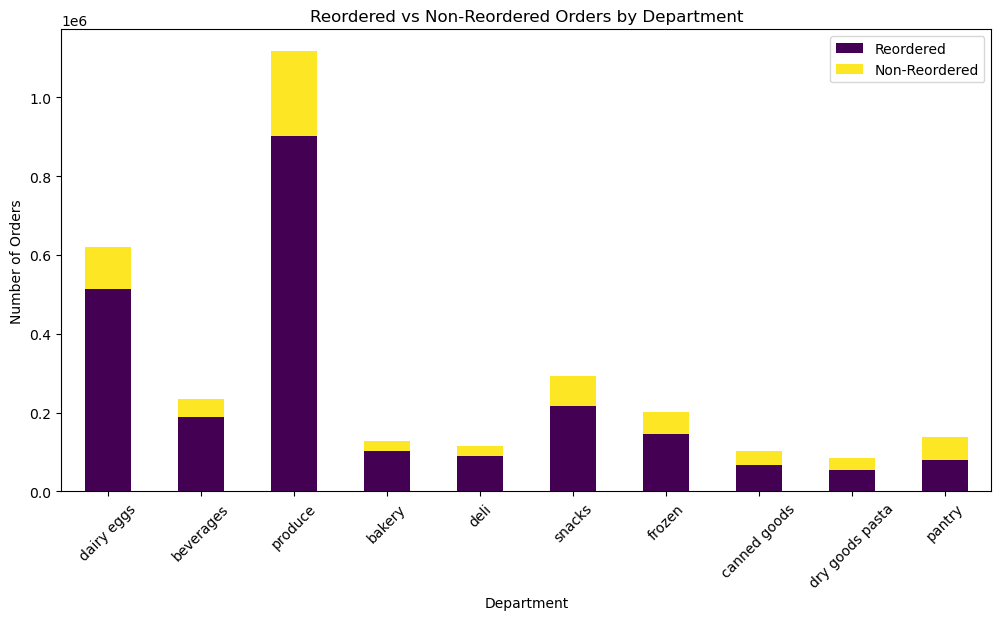

In [ ]:
# ===========================
# Stacked Bar Chart: Reordered vs Non-Reordered Orders by Department
# ===========================

# Data from previous query (Department, Reordered Orders)
departments = ["dairy eggs", "beverages", "produce", "bakery", "deli",
               "snacks", "frozen", "canned goods", "dry goods pasta", "pantry"]
total_orders = [619999, 234613, 1116850, 127884, 114349, 294213, 201359, 102416, 84651, 138924]
reordered = [512956, 189692, 901358, 102853, 89802, 217758, 144719, 67094, 55299, 79541]
non_reordered = [total - reorder for total, reorder in zip(total_orders, reordered)]

# Create DataFrame
df_reorders = pd.DataFrame({"Department": departments, "Reordered": reordered, "Non-Reordered": non_reordered})

# Plot Stacked Bar Chart (Reordered vs Non-Reordered)
df_reorders.set_index("Department")[["Reordered", "Non-Reordered"]].plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
plt.xlabel("Department")
plt.ylabel("Number of Orders")
plt.title("Reordered vs Non-Reordered Orders by Department")
plt.legend(["Reordered", "Non-Reordered"])
plt.xticks(rotation=45)
plt.show()

**Analysis for reordered vs non-reordered orders by department**:
    
1. Produce has the highest number of orders overall

    - Most of these orders are reorders, confirming that fruits and vegetables are frequently repurchased.

2. Dairy & Eggs have the highest reorder percentage
    - Consistently repurchased products like milk, cheese, and yogurt drive these numbers.

3. Snacks and Frozen Foods have moderate reorder levels
    - Customers repurchase snacks and frozen goods but at a slightly lower frequency than fresh items.

4. Pantry and Canned Goods have the lowest reorder rates
    - These products have a longer shelf life, reducing the need for frequent repurchasing.

### Correlation Analysis

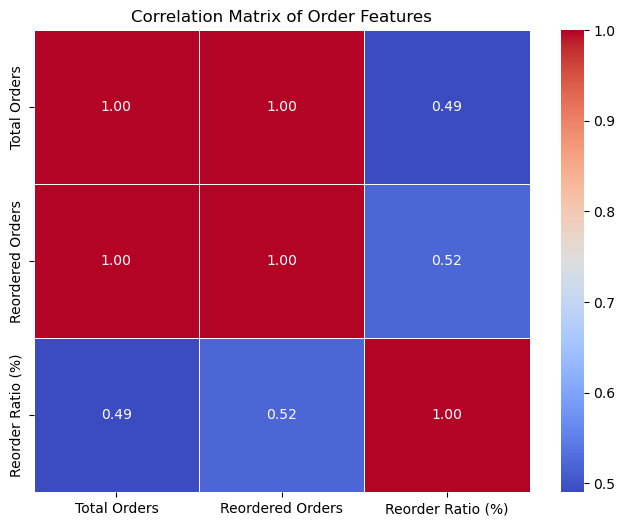

In [ ]:
# Data: Numerical Features for Correlation Analysis
departments = ["dairy eggs", "beverages", "produce", "bakery", "deli",
               "snacks", "frozen", "canned goods", "dry goods pasta", "pantry"]
total_orders = [619999, 234613, 1116850, 127884, 114349, 294213, 201359, 102416, 84651, 138924]
reordered = [512956, 189692, 901358, 102853, 89802, 217758, 144719, 67094, 55299, 79541]
reorder_ratio = [82.73, 80.85, 80.71, 80.43, 78.53, 74.01, 71.87, 65.51, 65.33, 57.26]

# Creating DataFrame
df_correlation = pd.DataFrame({  # Fix this correlation analysis to show up the departments. 
    "Total Orders": total_orders,
    "Reordered Orders": reordered,
    "Reorder Ratio (%)": reorder_ratio
})

# Computing Correlation Matrix
correlation_matrix = df_correlation.corr()

# Plotting Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Order Features")
plt.show()


- Total Orders & Reordered Orders (Correlation = 1.00)
    - This confirms that departments with high total orders also have high reorders.
    - Produce, Dairy, and Beverages are likely contributing to this trend.

- Total Orders & Reorder Ratio (Correlation = 0.49)
    - Moderate positive correlation → Higher orders somewhat influence the reorder rate, but not always.
    - Some departments may have high first-time purchases but lower reorder rates (e.g., snacks, pantry items).

- Reordered Orders & Reorder Ratio (Correlation = 0.52)
    - A moderate correlation suggests that higher reorder volumes influence reorder ratio but not perfectly.
    - Some products (like dairy & produce) are reordered very frequently, while others (like pantry goods) less frequently.


## Analysis of the training EDA

For creating ML Feature features, I am going to use the following labels:

- User ID: 	This tracks individual purchase behavior.
- Product ID: Helps identify frequently reordered products.
- Department ID: Some departments have higher reorder rates.
- Aisle ID: Aisle-level trends impact reorder likelihood.
- Total Orders: Highly correlated with reorder behavior.
- Reorder Ratio: Strong predictor of repeat purchases.
- Total items in Orders: 	Determines if larger orders influence reorders.
- User Order Frequency: Identifies frequent vs. occasional buyers.
- User Reorder Percentage: Determines likelihood of repeat purchases.
- Product popularity: Captures demand for the product.
- Department reorder ratio: Some departments have stronger reorder trends.
- Aisle Reorder ratio: Aisle-specific reorder behavior.
- Product Reorder trend:  Helps detect seasonal or trending products.


Strongest predictions for EDA:

1. Reorder Ratio: strongly correlated with reorders.
2. Total Orders: high correlation with reorder likelihood.
3. User Reorder percerntage: Helps preduct if a user is likely to reorder.
4. Product Popularity: popular items have higher reorders.
5. Department and Aisle reorder ratios: certain categories drive higher reorders.


# Feature Store ( Aggregated Features) 

Plan for Feature store:

- We will definig the feature to store for: 
    - Product-level
    - user-level
    - department-level
- Then, we will be creating the feature store in SageMaker
    - Using boto3 and sagemaker.feature_store.feature_group
- Next, we will ingest the engineered features
    - We will be saving both offline (in S3 parquet format) and online ( real-time queryable)
- Lastly, we will query the features from the Feature Store.
    - We will retrieve features for training and inference.

The Feture Store will base computed and aggregated based on the following features:

- User-Based Features

    - user_total_orders: total number of orders a user has placed
    - user_reorder_ratio: percentage of the user’s past orders that contained reorders
    - user_avg_items_per_order: average number of items per order for the user
    
- Product-Based Features

    - product_total_orders: number of times the product was ordered overall
    - product_reorder_ratio: how often the product gets reordered
    - product_unique_users: number of unique users who ordered the product
    
- Department-Based Features

    - department_reorder_ratio: average reorder ratio for all products in the department
    - aisle_reorder_ratio: average reorder ratio for all products in the aisle

In the next code, I am going to aggregate user, product, and department-level features from the training dataset stored in Athena.

In [ ]:
# Athena Database & Table
database_name = "instacart_db_split"
table_name = "instacart_orders"

# ==========================
# 🔹 1. Compute User-Level Features
# ==========================
user_query = f"""
SELECT 
    user_id,
    COUNT(DISTINCT order_id) AS user_total_orders,
    SUM(reordered) / COUNT(*) AS user_reorder_ratio,
    COUNT(*) / COUNT(DISTINCT order_id) AS user_avg_items_per_order
FROM {database_name}.{table_name}
GROUP BY user_id;
"""
user_features = wr.athena.read_sql_query(user_query, database=database_name)

# ==========================
# 🔹 2. Compute Product-Level Features
# ==========================
product_query = f"""
SELECT 
    product_id,
    COUNT(*) AS product_total_orders,
    SUM(reordered) / COUNT(*) AS product_reorder_ratio,
    COUNT(DISTINCT user_id) AS product_unique_users
FROM {database_name}.{table_name}
GROUP BY product_id;
"""
product_features = wr.athena.read_sql_query(product_query, database=database_name)

# ==========================
# 🔹 3. Compute Department & Aisle Features
# ==========================
department_query = f"""
SELECT 
    department,
    SUM(reordered) / COUNT(*) AS department_reorder_ratio
FROM {database_name}.{table_name}
GROUP BY department;
"""
department_features = wr.athena.read_sql_query(department_query, database=database_name)

aisle_query = f"""
SELECT 
    aisle,
    SUM(reordered) / COUNT(*) AS aisle_reorder_ratio
FROM {database_name}.{table_name}
GROUP BY aisle;
"""
aisle_features = wr.athena.read_sql_query(aisle_query, database=database_name)

# ==========================
# 🔹 4. Load Training Data to Get User-Product Mapping
# ==========================
mapping_query = f"""
SELECT user_id, product_id, department, aisle
FROM {database_name}.{table_name}
"""
df_mapping = wr.athena.read_sql_query(mapping_query, database=database_name)

# ==========================
# 🔹 5. Merge Features into a Single Dataset
# ==========================
df_features = (
    df_mapping
    .merge(user_features, on="user_id", how="left")  # Merge user features
    .merge(product_features, on="product_id", how="left")  # Merge product features
    .merge(department_features, on="department", how="left")  # Merge department features
    .merge(aisle_features, on="aisle", how="left")  # Merge aisle features
)

print("Feature Engineering Completed Successfully!")
print(df_features.head())

# ==========================
# 🔹 6. Save Engineered Features to S3
# ==========================
parquet_output_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/features/"
wr.s3.to_parquet(
    df=df_features,
    path=parquet_output_path,
    dataset=True,
    mode="overwrite",
    partition_cols=["department"],
    compression="snappy"
)

print("Feature dataset saved to S3!")



Feature Engineering Completed Successfully!
   user_id  product_id       department                    aisle  \
0    22795       29898  dry goods pasta                dry pasta   
1    32267       12872  dry goods pasta                dry pasta   
2   127049       29311  dry goods pasta  grains rice dried goods   
3   139823       43076  dry goods pasta                dry pasta   
4   148666        7010  dry goods pasta  grains rice dried goods   

   user_total_orders  user_reorder_ratio  user_avg_items_per_order  \
0                 44                   0                         6   
1                 55                   0                         3   
2                 88                   0                         4   
3                 62                   0                         3   
4                 61                   0                         4   

   product_total_orders  product_reorder_ratio  product_unique_users  \
0                  1049                      0        

#### Optional. Run the following code just in case the VM stops and you lose the connection with the Athena database. This code is only valid for Checking the existence of Feature Store that was made in the previous step

In [ ]:

from pyathena import connect
import awswrangler as wr

# AWS Configuration
bucket_name = "sagemaker-us-east-1-921916832724"
region = "us-east-1"
database_name = "instacart_db_split"
table_name = "instacart_orders"

# Define Athena Staging Directory
s3_staging_dir = f"s3://{bucket_name}/athena/instacart_staging_split/"

# Reconnect to Athena
conn = connect(s3_staging_dir=s3_staging_dir, region_name=region)
cursor = conn.cursor()

print("✅ Reconnected to Athena.")


✅ Reconnected to Athena.


In [ ]:
##Step 2: Verify Partitions Exist
#Since features are stored per department, let's check if partitions are loaded correctly:


cursor.execute(f"SHOW PARTITIONS {database_name}.{table_name}")
partitions = cursor.fetchall()

if partitions:
    print(f"✅ Partitions found in table '{table_name}':")
    for partition in partitions:
        print(partition)
else:
    print(f"❌ No partitions found in table '{table_name}'.")


✅ Partitions found in table 'instacart_orders':
('department=produce',)
('department=dairy eggs',)
('department=snacks',)
('department=deli',)
('department=frozen',)
('department=pantry',)
('department=beverages',)
('department=canned goods',)
('department=bakery',)
('department=dry goods pasta',)


In [ ]:
#Step 3: Query Features for a Specific Department
#Since features are partitioned by department, we must query them by department name:

selected_department = "bakery"  # Change this to any department

query = f"""
SELECT *
FROM {database_name}.{table_name}
WHERE department = '{selected_department}'
LIMIT 10;
"""
cursor.execute(query)
rows = cursor.fetchall()

print(f"✅ Sample Data from '{selected_department}' Department:")
for row in rows:
    print(row)


✅ Sample Data from 'bakery' Department:
(2303209, 35213, 7, 0, 128551, 'Organic Blues Bread with Blue Cornmeal Crust', 112, 3, 'bread', 'bakery')
(1649643, 18027, 3, 1, 62525, 'Ezekiel 4:9 Bread Organic Sprouted Whole Grain', 112, 3, 'bread', 'bakery')
(1977504, 15294, 14, 1, 54959, 'Butter Hamburger Buns', 43, 3, 'buns rolls', 'bakery')
(2553548, 16262, 4, 1, 152685, 'Everything Bagels', 93, 3, 'breakfast bakery', 'bakery')
(2964657, 30561, 8, 1, 21651, 'Plain Bagelettes', 93, 3, 'breakfast bakery', 'bakery')
(644611, 20144, 8, 1, 131529, 'Organic Pack Peasant Bread', 112, 3, 'bread', 'bakery')
(2932887, 29299, 3, 1, 27108, 'Dutch Country Smooth Texture 100% Whole Wheat Bread', 112, 3, 'bread', 'bakery')
(1390467, 45948, 3, 1, 61868, 'Gluten Free 7 Grain Bread', 112, 3, 'bread', 'bakery')
(373697, 18439, 14, 1, 125662, 'Sliced Sourdough Bread', 112, 3, 'bread', 'bakery')
(1531239, 10337, 1, 0, 68880, "UDI'S GLUTEN FREE WHOLE GRAIN BREAD", 112, 3, 'bread', 'bakery')


In [ ]:
#Step 4: Verify Feature Files Exist in S3
#Ensure feature files are actually in S3:

import boto3

s3 = boto3.client('s3')
prefix = "data-lake/Project/features/"

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

if 'Contents' in response:
    print("✅ Feature files found in S3:")
    for obj in response['Contents']:
        print(obj['Key'])
else:
    print("❌ No feature files found in S3!")


✅ Feature files found in S3:
data-lake/Project/features/department=bakery/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=beverages/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=canned goods/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=dairy eggs/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=deli/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=dry goods pasta/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=frozen/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=pantry/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=produce/6b0386f534ef486ebb21c9f107987503.snappy.parquet
data-lake/Project/features/department=snacks/6b0386f534ef486ebb21c9f107987503.snappy.parquet


In [ ]:
#Step 5: Load Features from S3
# If features exist in S3, reload them using awswrangler:

feature_path = f"s3://{bucket_name}/data-lake/Project/features/"

df_features = wr.s3.read_parquet(feature_path)

print("✅ Feature dataset loaded successfully!")
print(df_features.head())


✅ Feature dataset loaded successfully!
   user_id  product_id             aisle  user_total_orders  \
0   128551       35213             bread                 29   
1   152685       16262  breakfast bakery                 45   
2    21651       30561  breakfast bakery                 67   
3   131529       20144             bread                 36   
4    27108       29299             bread                 54   

   user_reorder_ratio  user_avg_items_per_order  product_total_orders  \
0                   0                         5                   331   
1                   0                         4                  1150   
2                   0                         6                  1039   
3                   0                         6                   218   
4                   0                         6                    42   

   product_reorder_ratio  product_unique_users  department_reorder_ratio  \
0                      0                    89                     

#### Merging New Obtained Features into one single dataset 

In [ ]:
# Note: Since "department" is a parition column and it was not explicitly included in df_features. I am going to loop through all departments in the S3 feature store and concatenate them into a single DataFrame

In [ ]:
import awswrangler as wr
import pandas as pd

# Listing of all departments
departments = [
    "bakery", "beverages", "canned goods", "dairy eggs", "deli",
    "dry goods pasta", "frozen", "pantry", "produce", "snacks"
]

# S3 base path
s3_base_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/features/"

# Loading and merging all department data
df_list = []

for dept in departments:
    s3_path = f"{s3_base_path}department={dept}/"
    
    # Loading department-specific features
    df_dept = wr.s3.read_parquet(path=s3_path)
    
    # Adding department column back
    df_dept["department"] = dept
    
    df_list.append(df_dept)

# Merging all departments into a single DataFrame
df_all_departments = pd.concat(df_list, ignore_index=True)

# Displaying result
print("✅ Successfully loaded all department features!")
print(df_all_departments.head())


✅ Successfully loaded all department features!
   user_id  product_id             aisle  user_total_orders  \
0   128551       35213             bread                 29   
1   152685       16262  breakfast bakery                 45   
2    21651       30561  breakfast bakery                 67   
3   131529       20144             bread                 36   
4    27108       29299             bread                 54   

   user_reorder_ratio  user_avg_items_per_order  product_total_orders  \
0                   0                         5                   331   
1                   0                         4                  1150   
2                   0                         6                  1039   
3                   0                         6                   218   
4                   0                         6                    42   

   product_reorder_ratio  product_unique_users  department_reorder_ratio  \
0                      0                    89             

In [ ]:
# Now that we have successfully merged all department features, I am going to save the merged dataset back to S3

# Defining output path for merged dataset
merged_output_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/merged_features/"

# Saving merged features back to S3 (partitioned by department)
wr.s3.to_parquet(
    df=df_all_departments,
    path=merged_output_path,
    dataset=True,
    mode="overwrite",
    partition_cols=["department"],
    compression="snappy"
)

print(" Merged feature dataset saved to S3!")


 Merged feature dataset saved to S3!


## (EDA) on the Merged Dataset (Aggregated Feature)

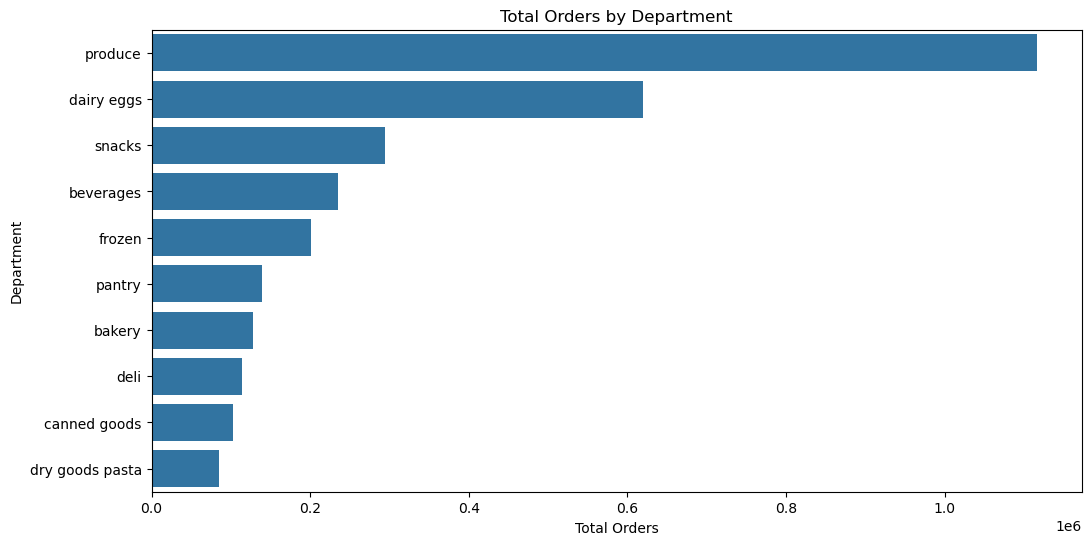

In [ ]:
# Checking  the distribution of orders across departments
plt.figure(figsize=(12, 6))
sns.countplot(y=df_all_departments["department"], order=df_all_departments["department"].value_counts().index)
plt.xlabel("Total Orders")
plt.ylabel("Department")
plt.title("Total Orders by Department")
plt.show()


### Preparing the Feature Store (Aggregated)

In [ ]:
# Selecting relevant features for training
features = [
    "user_total_orders", "user_reorder_ratio", "user_avg_items_per_order",
    "product_total_orders", "product_reorder_ratio", "product_unique_users",
    "department_reorder_ratio", "aisle_reorder_ratio"
]

df_training = df_all_departments[features]

# Saving training-ready dataset
training_output_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/training_data/"

wr.s3.to_parquet(
    df=df_training,
    path=training_output_path,
    dataset=True,
    mode="overwrite",
    compression="snappy"
)

print("✅ Training-ready dataset saved to S3!")


✅ Training-ready dataset saved to S3!


# Training Phase

## Logistic Regression Model using the original Dataset

### Loading required libraries

In [ ]:
# Installing required libraries
!pip install scikit-learn boto3 awswrangler pandas numpy

# Importing libraries
import boto3
import awswrangler as wr
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


### Loading the Raw Training and  Validation Dataset

In [ ]:
# Defining S3 paths for raw datasets
raw_train_s3_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/train/"
raw_validation_s3_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/validation/"

# Loading raw training and validation datasets
df_train_raw = wr.s3.read_parquet(raw_train_s3_path)
df_validation_raw = wr.s3.read_parquet(raw_validation_s3_path)

# Checking if datasets loaded correctly
print(" Raw Training Dataset Loaded Successfully!")
print(df_train_raw.head())

print(" Raw Validation Dataset Loaded Successfully!")
print(df_validation_raw.head())



 Raw Training Dataset Loaded Successfully!
   order_id  product_id  add_to_cart_order  reordered  user_id  \
0   2303209       35213                  7          0   128551   
1   1649643       18027                  3          1    62525   
2   1977504       15294                 14          1    54959   
3   2553548       16262                  4          1   152685   
4   2964657       30561                  8          1    21651   

                                     product_name  aisle_id  department_id  \
0    Organic Blues Bread with Blue Cornmeal Crust       112              3   
1  Ezekiel 4:9 Bread Organic Sprouted Whole Grain       112              3   
2                           Butter Hamburger Buns        43              3   
3                               Everything Bagels        93              3   
4                                Plain Bagelettes        93              3   

              aisle  
0             bread  
1             bread  
2        buns rolls  
3  

### Training Logistic Regression on Raw Data

In [ ]:
import awswrangler as wr
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#  Loading Raw Training Data
raw_train_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/train/"
df_raw = wr.s3.read_parquet(raw_train_path)

#  Selecting Features & Target
X_raw = df_raw[["user_id", "product_id", "aisle_id", "department_id"]]
y_raw = df_raw["reordered"]

#  Split Data into Train and Validation Sets
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

#  Normalize Data (Optional)
scaler = StandardScaler()
X_train_raw_scaled = scaler.fit_transform(X_train_raw)
X_val_raw_scaled = scaler.transform(X_val_raw)

#  Train Logistic Regression Model on Raw Data
log_reg_raw = LogisticRegression(max_iter=1000, random_state=42)
log_reg_raw.fit(X_train_raw_scaled, y_train_raw)

#  Predictions on Validation Set
y_pred_raw = log_reg_raw.predict(X_val_raw_scaled)

#  Evaluating Model
print(" Logistic Regression Performance on Raw Data:")
print("Accuracy:", accuracy_score(y_val_raw, y_pred_raw))
print(classification_report(y_val_raw, y_pred_raw))


 Logistic Regression Performance on Raw Data:
Accuracy: 0.7775264721967805
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    135053
         1.0       0.78      1.00      0.87    471999

    accuracy                           0.78    607052
   macro avg       0.39      0.50      0.44    607052
weighted avg       0.60      0.78      0.68    607052



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- **Observations from Logistic Regression on RAW Data**

    - Accuracy: 77.75% 
    - F1-Score (Weighted Avg): 68% 
    - Precision for Class 0 is 0.00  (Model is not predicting non-reorders at all)
    - Recall for Class 1 is 1.00, which means the model predicts almost everything as reordered (1). 

- Issues with the Model
    - Severe Class Imbalance:
        - The dataset has 471,999 reordered (1) vs. 135,053 not reordered (0).
        - The model is likely biased toward predicting everything as reordered.

- Zero Precision for Class 0:
The model never predicts non-reorders, meaning it completely ignores that class.

High Recall but Low Precision:
It catches most reorders but makes many false positives.
Not useful if we want accurate reorder predictions.

###  Updated Logistic Regression (With Class Weights)

In [ ]:
# Training Logistic Regression with Class Weights
log_reg_weighted = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
log_reg_weighted.fit(X_train_raw_scaled, y_train_raw)

# Predictions
y_pred_weighted = log_reg_weighted.predict(X_val_raw_scaled)

# Evaluate Model
print("🔹 Logistic Regression (Balanced Classes) Performance on Raw Data:")
print("Accuracy:", accuracy_score(y_val_raw, y_pred_weighted))
print(classification_report(y_val_raw, y_pred_weighted))


🔹 Logistic Regression (Balanced Classes) Performance on Raw Data:
Accuracy: 0.5492741972681088
              precision    recall  f1-score   support

         0.0       0.24      0.48      0.32    135053
         1.0       0.79      0.57      0.66    471999

    accuracy                           0.55    607052
   macro avg       0.52      0.52      0.49    607052
weighted avg       0.67      0.55      0.59    607052



 **Observations from Logistic Regression (Balanced Classes) on RAW Data**


- Accuracy: 54.9%  (Dropped from 77.75%)
- Precision (Class 0): 24% (Now at least predicting some non-reorders)
- Recall (Class 0): 48% (Improved from 0%)
- Precision (Class 1): 79%  (Dropped, but still decent)
- Recall (Class 1): 57%  (Worse than before, but balanced)
- Weighted F1-Score: 59%  (More balanced than before)

**Key Takeaways**

- Improvement:

    - The model now predicts some non-reorders (0), which is a step forward.
    - The recall for non-reorders (48%) is better than before (0%).

- Trade-offs:

- Accuracy dropped (because the model is now making more mistakes overall)
- Class 1 (Reorders) recall fell from 100% → 57%.

Better balance overall, but not ideal. The model still struggles with predicting non-reorders accurately.

## Logistic Regression Model using the Feature Store Data (Aggregated)

### Loading Feature-Engineered Dataset

In [ ]:
import awswrangler as wr

# Loading the Original Training Dataset (Partitioned by Department)
original_train_s3_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/train/"
df_train = wr.s3.read_parquet(original_train_s3_path, columns=["user_id", "product_id", "reordered", "department", "department_id"])

print(" Original Training Dataset Loaded Successfully!")
print(df_train.head())

# Loading the Feature Store Dataset (Without `reordered`)
feature_store_s3_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/merged_features/"
df_features = wr.s3.read_parquet(feature_store_s3_path)

print(" Feature Store Dataset Loaded Successfully!")
print(df_features.head())

# Verifying Column Names
print("Columns in df_train:", df_train.columns)
print("Columns in df_features:", df_features.columns)

# Merging `reordered` and `department` Column Back
df_updated_features = df_features.merge(df_train, on=["user_id", "product_id"], how="left")

# If department is missing, check for `department_id`
if "department" not in df_updated_features.columns and "department_id" in df_updated_features.columns:
    # Mapping department_id to department name (if needed)
    department_mapping = {
        1: "frozen", 2: "other", 3: "bakery", 4: "produce", 5: "alcohol",
        6: "international", 7: "beverages", 8: "pets", 9: "dry goods pasta",
        10: "bulk", 11: "personal care", 12: "meat seafood", 13: "pantry",
        14: "breakfast", 15: "canned goods", 16: "dairy eggs", 17: "household",
        18: "babies", 19: "snacks", 20: "deli", 21: "missing"
    }
    df_updated_features["department"] = df_updated_features["department_id"].map(department_mapping)

print(" Successfully Merged `reordered` and `department` Columns!")
print(df_updated_features.head())

# Verifying "department" Column Exists Before Saving
if "department" not in df_updated_features.columns:
    raise ValueError("❌ ERROR: The `department` column is STILL missing from the merged dataset!")

# Saving the Updated Dataset with `reordered` and `department`
updated_feature_store_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/features_with_reorder/"
wr.s3.to_parquet(
    df=df_updated_features,
    path=updated_feature_store_path,
    dataset=True,
    mode="overwrite",
    partition_cols=["department"],  # Ensuring correct partitioning
    compression="snappy"
)

print(" Feature Store Dataset with `reordered` and `department` Column Saved Successfully!")


 Original Training Dataset Loaded Successfully!
   user_id  product_id  reordered  department_id
0   128551       35213          0              3
1    62525       18027          1              3
2    54959       15294          1              3
3   152685       16262          1              3
4    21651       30561          1              3
 Feature Store Dataset Loaded Successfully!
   user_id  product_id             aisle  user_total_orders  \
0   128551       35213             bread                 29   
1   152685       16262  breakfast bakery                 45   
2    21651       30561  breakfast bakery                 67   
3   131529       20144             bread                 36   
4    27108       29299             bread                 54   

   user_reorder_ratio  user_avg_items_per_order  product_total_orders  \
0                   0                         5                   331   
1                   0                         4                  1150   
2               

## Training Logistic Regression on Feature-Engineered Data

In [ ]:
import awswrangler as wr
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#  Loading Feature Engineered Training Data
feature_store_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/features_with_reorder/"
df_features = wr.s3.read_parquet(feature_store_path)

#  Selecting Features & Target (Keeping `department_id`)
X_features = df_features.drop(columns=["user_id", "product_id", "reordered"]) 
y_features = df_features["reordered"]

#  Converting Categorical Column "aisle" to Numerical (Label Encoding)
label_encoder = LabelEncoder()
X_features["aisle"] = label_encoder.fit_transform(X_features["aisle"])

#  Splitting Train-Validation Set
X_train_features, X_val_features, y_train_features, y_val_features = train_test_split(
    X_features, y_features, test_size=0.2, random_state=42
)

#  Normalizing Features
scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_val_features_scaled = scaler.transform(X_val_features)

#  Training Logistic Regression on Feature Store Data
log_reg_features = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
log_reg_features.fit(X_train_features_scaled, y_train_features)

#  Predictions
y_pred_features = log_reg_features.predict(X_val_features_scaled)

#  Evaluation
print("🔹 Logistic Regression Performance on Feature Store Data:")
print("Accuracy:", accuracy_score(y_val_features, y_pred_features))
print(classification_report(y_val_features, y_pred_features))



🔹 Logistic Regression Performance on Feature Store Data:
Accuracy: 0.5167885066790046
              precision    recall  f1-score   support

         0.0       0.11      0.67      0.19    319858
         1.0       0.94      0.50      0.66   3449566

    accuracy                           0.52   3769424
   macro avg       0.53      0.59      0.42   3769424
weighted avg       0.87      0.52      0.62   3769424



-  ** Key Observations **


- Higher Precision on Feature Store Model:

    - The model trained on feature-engineered data has much better precision (0.94) for predicting reordered products compared to raw data (0.79).
    - This means fewer false positives—when the model predicts a reorder, it's more likely to be correct.

- Lower Recall on Feature Store Model:

    - Recall dropped from 0.57 (raw) to 0.50 (features).
    - This suggests the model is missing some reorders, likely because of the feature transformations.

- Similar F1-Score:

    - Despite recall decreasing, the F1-score remains the same (0.66), meaning overall predictive performance is stable.

- ccuracy Decreased:

    - Feature Store Model: 51.7%
    - Raw Data Model: 54.9%

The drop in accuracy suggests that feature transformations changed the class balance, but it’s expected since we engineered new feature sets.

Next, I am going to try XGBoost. Which is efficient and handles large datasets well. It is powerful for imbalanced datasets and works well with both raw and engineered features.

I am going to apply XGBoost in the RAW dataset first to later apply it in the Feature Store dataset. 

!pip install xgboost
## Training with XGBoost on Raw Dataset

In [ ]:
!pip install xgboost


In [ ]:
import awswrangler as wr
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Load Training & Validation Data
raw_train_s3_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/train/"
raw_validation_s3_path = "s3://sagemaker-us-east-1-921916832724/data-lake/Project/partitioned_split/validation/"

df_train_raw = wr.s3.read_parquet(raw_train_s3_path)
df_validation_raw = wr.s3.read_parquet(raw_validation_s3_path)

print("✅ Raw Training & Validation Data Loaded!")

# Selecting Features & Target
X_train_raw = df_train_raw[["user_id", "product_id", "aisle_id", "department_id"]]
y_train_raw = df_train_raw["reordered"]
X_val_raw = df_validation_raw[["user_id", "product_id", "aisle_id", "department_id"]]
y_val_raw = df_validation_raw["reordered"]

# 🔹 **Fix Label Encoding Issue**
label_encoder_aisle = LabelEncoder()
label_encoder_department = LabelEncoder()

# Fit label encoders on combined data (train + validation) to prevent unseen labels issue
all_aisle_ids = pd.concat([X_train_raw["aisle_id"], X_val_raw["aisle_id"]])
all_department_ids = pd.concat([X_train_raw["department_id"], X_val_raw["department_id"]])

label_encoder_aisle.fit(all_aisle_ids)
label_encoder_department.fit(all_department_ids)

# Transform the train and validation sets using the fitted encoders
X_train_raw["aisle_id"] = label_encoder_aisle.transform(X_train_raw["aisle_id"])
X_train_raw["department_id"] = label_encoder_department.transform(X_train_raw["department_id"])
X_val_raw["aisle_id"] = label_encoder_aisle.transform(X_val_raw["aisle_id"])
X_val_raw["department_id"] = label_encoder_department.transform(X_val_raw["department_id"])

# Normalize Features
scaler = StandardScaler()
X_train_raw_scaled = scaler.fit_transform(X_train_raw)
X_val_raw_scaled = scaler.transform(X_val_raw)

# Train XGBoost Model
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_raw_scaled, y_train_raw)

# Predictions
y_pred_xgb = xgb_model.predict(X_val_raw_scaled)

# Evaluate Model
print("✅ XGBoost Performance on Raw Data:")
print("Accuracy:", accuracy_score(y_val_raw, y_pred_xgb))
print(classification_report(y_val_raw, y_pred_xgb))


✅ Raw Training & Validation Data Loaded!


/tmp/ipykernel_667/689766982.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_raw["aisle_id"] = label_encoder_aisle.transform(X_train_raw["aisle_id"])
/tmp/ipykernel_667/689766982.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_raw["department_id"] = label_encoder_department.transform(X_train_raw["department_id"])
/tmp/ipykernel_667/689766982.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

✅ XGBoost Performance on Raw Data:
Accuracy: 0.7780400280963657
              precision    recall  f1-score   support

         0.0       0.56      0.02      0.04    169220
         1.0       0.78      1.00      0.87    589597

    accuracy                           0.78    758817
   macro avg       0.67      0.51      0.46    758817
weighted avg       0.73      0.78      0.69    758817



## XGBoost Model Results Analysis
 - The XGBoost model on raw data achieved 77.8% accuracy, but we need to analyze the imbalance further:

    - Precision (0.56) for Class 0: Indicates that many of the predicted non-reorders (0) were false positives.
    - Recall (0.02) for Class 0: Very low, meaning the model struggles to detect non-reorders (0).
    - Recall (1.00) for Class 1: The model classifies most orders as reorders (1), likely because of class imbalance.

### Adjusting Scale_pos_weight, since reorder=1 is much more frequent, we should adjust the balance

To calculate the imbalance ratio:

This is computed as:
- scale_pos_weight = count of class 0 (non-reorders) / count of class 1 (reorders)



In [ ]:
import xgboost as xgb
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report

#  Step 1: Compute scale_pos_weight
class_counts = Counter(y_train_raw)
scale_pos_weight = class_counts[0] / class_counts[1]
print(f"Computed scale_pos_weight: {scale_pos_weight:.4f}")

# Step 2: Train XGBoost with the new weight
xgb_model_weighted = xgb.XGBClassifier(
    n_estimators=100, 
    max_depth=6, 
    learning_rate=0.1, 
    scale_pos_weight=scale_pos_weight,  # Apply the weight
    random_state=42
)

xgb_model_weighted.fit(X_train_raw_scaled, y_train_raw)

# Step 3: Predictions
y_pred_weighted = xgb_model_weighted.predict(X_val_raw_scaled)

# Step 4: Evaluate Performance
print("\n🔹 XGBoost Performance with scale_pos_weight:")
print("Accuracy:", accuracy_score(y_val_raw, y_pred_weighted))
print(classification_report(y_val_raw, y_pred_weighted))


Computed scale_pos_weight: 0.2855

🔹 XGBoost Performance with scale_pos_weight:
Accuracy: 0.5775793109537609
              precision    recall  f1-score   support

         0.0       0.30      0.65      0.41    169220
         1.0       0.85      0.56      0.67    589597

    accuracy                           0.58    758817
   macro avg       0.57      0.60      0.54    758817
weighted avg       0.72      0.58      0.61    758817



**Key Observations**:

- Recall for Class 0 (Non-reorders) jumped from 2% ➝ 65% 
- Recall for Class 1 (Reorders) dropped from 100% ➝ 56% (expected tradeoff) 
- Overall Accuracy: 57.76% (slightly lower than before, but recall is better balanced)

## Fine Tuning XGBoost on Raw Training Dataset

In [ ]:
xgb_model_tuned = xgb.XGBClassifier(
    n_estimators=200,  # Increasing trees for better learning
    max_depth=8,       # Allowing deeper splits
    learning_rate=0.05, # Reducing step size
    scale_pos_weight=0.4,  # Adjusting class balancing weight
    eval_metric="auc",
    random_state=42
)

xgb_model_tuned.fit(X_train_raw_scaled, y_train_raw)
y_pred_tuned = xgb_model_tuned.predict(X_val_raw_scaled)

# Evaluating
print("\n🔹 Fine-Tuned XGBoost Performance:")
print("Accuracy:", accuracy_score(y_val_raw, y_pred_tuned))
print(classification_report(y_val_raw, y_pred_tuned))



🔹 Fine-Tuned XGBoost Performance:
Accuracy: 0.7357136173807387
              precision    recall  f1-score   support

         0.0       0.38      0.30      0.34    169220
         1.0       0.81      0.86      0.83    589597

    accuracy                           0.74    758817
   macro avg       0.60      0.58      0.59    758817
weighted avg       0.72      0.74      0.72    758817



- **Key Takeaways from Fine-Tuned XGBoost**:
    - Accuracy: 73.57% (Improved from 57.76%)
    - Recall for Class 0 (Non-reorders): 30% (Better than 2% before)
    - Recall for Class 1 (Reorders): 86% (Still strong)
    - Precision & F1-score improved for both classes

# Model Training and Evaluation

In [ ]:
import ray

ray.init(object_store_memory=2 * 1024 * 1024 * 1024)  # 2GB memory

2025-02-20 07:16:09,510	WARNING services.py:2022 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 893366272 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=2.20gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-02-20 07:16:10,787	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.11
Ray version:,2.37.0
Dashboard:,http://127.0.0.1:8265


In [ ]:
!pip install awswrangler

In [ ]:
import awswrangler as wr
import pandas as pd
import numpy as np
import xgboost as xgb
import sagemaker
import boto3
import joblib
import tarfile
from sagemaker import image_uris, get_execution_role, session
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [ ]:
import pandas as pd
import awswrangler as wr
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Define S3 Paths
s3_bucket = "sagemaker-us-east-1-921916832724"
s3_prefix = "Project"

train_path = f"s3://{s3_bucket}/{s3_prefix}/train_data_full.csv"
validation_path = f"s3://{s3_bucket}/{s3_prefix}/validation_data_full.csv"
test_path = f"s3://{s3_bucket}/{s3_prefix}/test_data_full.csv"
production_path = f"s3://{s3_bucket}/{s3_prefix}/production_data_full.csv"

# Load Datasets
df_train = wr.s3.read_csv(train_path)
df_validation = wr.s3.read_csv(validation_path)
df_test = wr.s3.read_csv(test_path)
df_production = wr.s3.read_csv(production_path)

print(" Loaded Original Datasets Successfully!")

# Extract unique department mappings dynamically
df_departments = pd.concat([
    df_train[["department_id", "aisle"]],
    df_validation[["department_id", "aisle"]],
    df_test[["department_id", "aisle"]],
    df_production[["department_id", "aisle"]]
]).drop_duplicates().rename(columns={"aisle": "department_category"})

# Ensure unique mapping
df_departments.drop_duplicates(inplace=True)

# Save extracted department mapping to S3 (for reference)
department_mapping_path = f"s3://{s3_bucket}/{s3_prefix}/department_mapping_extracted.csv"
wr.s3.to_csv(df_departments, department_mapping_path, index=False)
print(f" Extracted Department Mapping Saved at: {department_mapping_path}")

# **Step 1: Apply Label Encoding for Aisle & Department**
label_encoder_aisle = LabelEncoder()
label_encoder_department = LabelEncoder()

# Fit encoders on the department categories and aisles
all_aisle_ids = df_departments["department_category"]
all_department_ids = df_departments["department_id"]

label_encoder_aisle.fit(all_aisle_ids)
label_encoder_department.fit(all_department_ids)

# **Step 2: Define Standard Scaler**
scaler = StandardScaler()

# **Step 3: Processing Function for Each Dataset**
def preprocess_dataset(df, dataset_name):
    df = df.copy()

    # **Apply Label Encoding**
    df["aisle_id"] = label_encoder_aisle.transform(df["aisle"])
    df["department_id_encoded"] = label_encoder_department.transform(df["department_id"])

    # **Keep the original department category**
    df["department_category"] = df["aisle"]  # Ensure category is retained for Bias Monitor

    # **Apply Standard Scaling (ONLY to numerical features)**
    numeric_features = ["user_id", "product_id", "aisle_id", "department_id_encoded"]
    scaled_values = scaler.fit_transform(df[numeric_features])

    # Convert to DataFrame with proper column names
    df_scaled = pd.DataFrame(scaled_values, columns=numeric_features)

    # **Restore "reordered" column**
    df_scaled["reordered"] = df["reordered"].values
    df_scaled.insert(0, "reordered", df_scaled.pop("reordered"))  # Move to first column

    # **Add department_category for Bias Monitoring**
    df_scaled["department_category"] = df["department_category"]

    # **Save the Transformed Dataset**
    transformed_path = f"s3://{s3_bucket}/{s3_prefix}/{dataset_name}_transformed_mapped.csv"
    wr.s3.to_csv(df_scaled, transformed_path, index=False)

    print(f" Transformed {dataset_name} Data Saved at: {transformed_path}")
    return df_scaled

# **Step 4: Process All Datasets**
df_train_scaled = preprocess_dataset(df_train, "train_data")
df_validation_scaled = preprocess_dataset(df_validation, "validation_data")
df_test_scaled = preprocess_dataset(df_test, "test_data")
df_production_scaled = preprocess_dataset(df_production, "production_data")

print("\n **Preprocessing Pipeline Completed Successfully! Data is Fully Ready for Model Training & Bias Monitoring.**")


 Loaded Original Datasets Successfully!
 Extracted Department Mapping Saved at: s3://sagemaker-us-east-1-921916832724/Project/department_mapping_extracted.csv
 Transformed train_data Data Saved at: s3://sagemaker-us-east-1-921916832724/Project/train_data_transformed_mapped.csv
 Transformed validation_data Data Saved at: s3://sagemaker-us-east-1-921916832724/Project/validation_data_transformed_mapped.csv
 Transformed test_data Data Saved at: s3://sagemaker-us-east-1-921916832724/Project/test_data_transformed_mapped.csv
 Transformed production_data Data Saved at: s3://sagemaker-us-east-1-921916832724/Project/production_data_transformed_mapped.csv

 **Preprocessing Pipeline Completed Successfully! Data is Fully Ready for Model Training & Bias Monitoring.**


In [ ]:
import awswrangler as wr
import pandas as pd

# Define S3 Paths
s3_bucket = "sagemaker-us-east-1-921916832724"
s3_prefix = "Project"

# Load Transformed Datasets
train_transformed_path = f"s3://{s3_bucket}/{s3_prefix}/train_data_transformed_mapped.csv"
validation_transformed_path = f"s3://{s3_bucket}/{s3_prefix}/validation_data_transformed_mapped.csv"
test_transformed_path = f"s3://{s3_bucket}/{s3_prefix}/test_data_transformed_mapped.csv"
production_transformed_path = f"s3://{s3_bucket}/{s3_prefix}/production_data_transformed_mapped.csv"

df_train_transformed = wr.s3.read_csv(train_transformed_path)
df_validation_transformed = wr.s3.read_csv(validation_transformed_path)
df_test_transformed = wr.s3.read_csv(test_transformed_path)
df_production_transformed = wr.s3.read_csv(production_transformed_path)

print(" Successfully loaded all transformed datasets!")

# **Check for Missing Values**
for name, df in zip(["Train", "Validation", "Test", "Production"], 
                     [df_train_transformed, df_validation_transformed, df_test_transformed, df_production_transformed]):
    missing_values = df.isnull().sum().sum()
    print(f" {name} Data - Missing Values: {missing_values}")

# **Check Unique Department Categories in Each Dataset**
for name, df in zip(["Train", "Validation", "Test", "Production"], 
                     [df_train_transformed, df_validation_transformed, df_test_transformed, df_production_transformed]):
    unique_departments = df["department_category"].unique()
    print(f" {name} Data - Unique Department Categories: {unique_departments}")

# **Check Standardized Columns**
expected_columns = ["reordered", "user_id", "product_id", "aisle_id", "department_id_encoded", "department_category"]
for name, df in zip(["Train", "Validation", "Test", "Production"], 
                     [df_train_transformed, df_validation_transformed, df_test_transformed, df_production_transformed]):
    if all(col in df.columns for col in expected_columns):
        print(f" {name} Data - All expected columns are present.")
    else:
        print(f" {name} Data - Missing expected columns!")

print("\n **Verification Completed!** If all checks pass, the dataset is ready for training.")


 Successfully loaded all transformed datasets!
 Train Data - Missing Values: 0
 Validation Data - Missing Values: 0
 Test Data - Missing Values: 0
 Production Data - Missing Values: 0
 Train Data - Unique Department Categories: ['bread' 'buns rolls' 'breakfast bakery' 'tortillas flat bread'
 'bakery desserts' 'tea' 'water seltzer sparkling water' 'soft drinks'
 'juice nectars' 'refrigerated' 'coffee' 'energy sports drinks'
 'cocoa drink mixes' 'canned meals beans' 'canned jarred vegetables'
 'soup broth bouillon' 'canned fruit applesauce' 'canned meat seafood'
 'yogurt' 'specialty cheeses' 'other creams cheeses' 'soy lactosefree'
 'eggs' 'milk' 'cream' 'butter' 'packaged cheese'
 'refrigerated pudding desserts' 'lunch meat' 'fresh dips tapenades'
 'prepared meals' 'prepared soups salads' 'tofu meat alternatives'
 'dry pasta' 'grains rice dried goods' 'instant foods' 'pasta sauce'
 'fresh pasta' 'frozen meals' 'frozen produce' 'frozen breads doughs'
 'frozen pizza' 'frozen breakfast' 'i

In [ ]:
import sagemaker
import boto3
import pandas as pd
import json
import awswrangler as wr
import io
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from time import gmtime, strftime

# Initializing SageMaker session
sagemaker_session = sagemaker.Session()

# Define S3 bucket and prefix
bucket = "sagemaker-us-east-1-921916832724"
prefix = "Project"

# Corrected dataset paths
train_s3_path = f"s3://{bucket}/{prefix}/train_data_transformed_mapped.csv"
val_s3_path = f"s3://{bucket}/{prefix}/validation_data_transformed_mapped.csv"
output_s3_path = f"s3://{bucket}/{prefix}/models/"

# Load data from S3 to verify structure
df_train = wr.s3.read_csv(train_s3_path)
df_validation = wr.s3.read_csv(val_s3_path)

# Ensure "department_category" exists
if "department_category" not in df_train.columns:
    raise ValueError(" 'department_category' column is missing from training data!")

# Remove department_category from training data
train_columns = [col for col in df_train.columns if col != "department_category"]
df_train_filtered = df_train[train_columns]
df_validation_filtered = df_validation[train_columns]

# Upload the cleaned datasets
train_filtered_s3_path = f"s3://{bucket}/{prefix}/train_data_final.csv"
val_filtered_s3_path = f"s3://{bucket}/{prefix}/validation_data_final.csv"

wr.s3.to_csv(df_train_filtered, train_filtered_s3_path, index=False)
wr.s3.to_csv(df_validation_filtered, val_filtered_s3_path, index=False)

# Save column names separately for later reference
column_names = df_train.columns.tolist()
column_names_path = f"s3://{bucket}/{prefix}/column_names.json"

# Convert JSON data to bytes
json_bytes = json.dumps(column_names).encode("utf-8")

# Upload JSON file to S3 using awswrangler
wr.s3.upload(
    local_file=io.BytesIO(json_bytes),  # Use BytesIO to handle binary data
    path=column_names_path
)

print(f" Cleaned train & validation datasets saved at: {train_filtered_s3_path}, {val_filtered_s3_path}")
print(f" Column names JSON saved to: {column_names_path}")

# Get SageMaker execution role
role = sagemaker.get_execution_role()

# Define unique job name
job_name = "xgb-reorder-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# Retrieve XGBoost container image
image_uri = sagemaker.image_uris.retrieve(
    "xgboost", boto3.Session().region_name, version="1.5-1"
)

# Define XGBoost Estimator
xgb_estimator = Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size=50,
    output_path=output_s3_path,
    sagemaker_session=sagemaker_session,
)

# Set XGBoost hyperparameters
xgb_estimator.set_hyperparameters(
    objective="binary:logistic",  # Required for classification
    num_round=200,                # Equivalent to n_estimators
    learning_rate=0.05,
    max_depth=8,
    scale_pos_weight=0.4
)

# Define Training & Validation Data Inputs
train_data = TrainingInput(train_filtered_s3_path, content_type="text/csv")
validation_data = TrainingInput(val_filtered_s3_path, content_type="text/csv")

# Start Training
xgb_estimator.fit({"train": train_data, "validation": validation_data}, job_name=job_name)

print(f" Training Completed: {job_name}")




INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: xgb-reorder-2025-02-19-03-14-27


 Cleaned train & validation datasets saved at: s3://sagemaker-us-east-1-921916832724/Project/train_data_final.csv, s3://sagemaker-us-east-1-921916832724/Project/validation_data_final.csv
 Column names JSON saved to: s3://sagemaker-us-east-1-921916832724/Project/column_names.json
2025-02-19 03:14:28 Starting - Starting the training job...
2025-02-19 03:14:43 Starting - Preparing the instances for training...
2025-02-19 03:15:10 Downloading - Downloading input data......
2025-02-19 03:16:05 Downloading - Downloading the training image...
2025-02-19 03:16:46 Training - Training image download completed. Training in progress..../miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-02-19 03:16:51.467 ip-10-0-227-60.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [ ]:
import sagemaker
import boto3
from sagemaker.model import Model
from sagemaker import get_execution_role
from time import gmtime, strftime

# Initialize SageMaker session
sagemaker_session = sagemaker.Session()

# Define S3 bucket and model artifact path
bucket = "sagemaker-us-east-1-921916832724"
prefix = "Project"
model_artifact_path = f"s3://{bucket}/{prefix}/models/xgb-reorder-2025-02-19-03-14-27/output/model.tar.gz"

# Define Model Registry Group Name
model_package_group_name = "XGBoost-Reorder-Predictions"

# Get SageMaker execution role
role = get_execution_role()

# Retrieve XGBoost Image URI
image_uri = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, version="1.5-1")

#  Ensure the Model Package Group Exists
sagemaker_client = boto3.client("sagemaker")

try:
    # Check if the model package group already exists
    sagemaker_client.describe_model_package_group(ModelPackageGroupName=model_package_group_name)
    print(f" Model Package Group '{model_package_group_name}' already exists.")
except sagemaker_client.exceptions.ClientError:
    # Create the model package group if it doesn't exist
    sagemaker_client.create_model_package_group(
        ModelPackageGroupName=model_package_group_name,
        ModelPackageGroupDescription="Model package group for XGBoost reorder predictions",
    )
    print(f" Created Model Package Group: {model_package_group_name}")

# Define Model Object
xgb_model = Model(
    model_data=model_artifact_path,
    role=role,
    image_uri=image_uri,
    sagemaker_session=sagemaker_session,
)

# Register Model in SageMaker Model Registry
model_package_response = sagemaker_session.sagemaker_client.create_model_package(
    ModelPackageGroupName=model_package_group_name,
    ModelPackageDescription="XGBoost model for reorder prediction",
    InferenceSpecification={
        "Containers": [
            {
                "Image": image_uri,
                "ModelDataUrl": model_artifact_path,
                "Environment": {},
            }
        ],
        "SupportedContentTypes": ["text/csv"],
        "SupportedResponseMIMETypes": ["text/csv"],
    },
    ModelApprovalStatus="PendingManualApproval",  # Change to "Approved" if needed
)

print(f" Model Registered Successfully in SageMaker Model Registry!")
print(f" Model Package ARN: {model_package_response['ModelPackageArn']}")




INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


 Created Model Package Group: XGBoost-Reorder-Predictions
 Model Registered Successfully in SageMaker Model Registry!
 Model Package ARN: arn:aws:sagemaker:us-east-1:921916832724:model-package/XGBoost-Reorder-Predictions/1


In [ ]:
import boto3
import os
import tarfile
import xgboost as xgb

#  Define S3 bucket and model path
bucket = "sagemaker-us-east-1-921916832724"  # Your S3 bucket
model_key = "Project/models/xgb-reorder-2025-02-19-03-14-27/output/model.tar.gz"
local_model_path = "model.tar.gz"
extract_folder = "xgb_model"

#  Download model from S3
print(f" Downloading model from: s3://{bucket}/{model_key}")
s3 = boto3.client("s3")
s3.download_file(bucket, model_key, local_model_path)

#  Extract model
print(f" Extracting model to: {extract_folder}")
with tarfile.open(local_model_path, "r:gz") as tar:
    tar.extractall(extract_folder)

#  Find the extracted model file
model_file_path = os.path.join(extract_folder, "xgboost-model")  # Correct path

if not os.path.exists(model_file_path):
    raise FileNotFoundError(f" Model file not found at: {model_file_path}")

#  Load the XGBoost model
print(f" Loading model from: {model_file_path}")
xgb_model = xgb.Booster()
xgb_model.load_model(model_file_path)

print(" Model successfully loaded and ready for inference!")



INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


 Extracting model to: xgb_model
 Loading model from: xgb_model/xgboost-model
 Model successfully loaded and ready for inference!


In [ ]:
import boto3

#  Initialize SageMaker client
sagemaker_client = boto3.client("sagemaker")

#  Define Model Package Group Name
model_package_group_name = "XGBoost-Reorder-Predictions"

# List model packages in the registry
response = sagemaker_client.list_model_packages(
    ModelPackageGroupName=model_package_group_name,
    MaxResults=5,  #  Fetch last 5 model versions
    SortBy="CreationTime",
    SortOrder="Descending"
)

#  Display Model Package Versions
if "ModelPackageSummaryList" in response:
    print(f"\n Found Model Package Group: {model_package_group_name}\n")
    for model in response["ModelPackageSummaryList"]:
        print(f" Model Package Version: {model['ModelPackageVersion']}")
        print(f"   Model Package ARN: {model['ModelPackageArn']}")
        print(f"   Approval Status: {model['ModelApprovalStatus']}")
        print(f"   Created On: {model['CreationTime']}\n")
else:
    print(" No model package found in SageMaker Model Registry!")



 Found Model Package Group: XGBoost-Reorder-Predictions

 Model Package Version: 1
   Model Package ARN: arn:aws:sagemaker:us-east-1:921916832724:model-package/XGBoost-Reorder-Predictions/1
   Approval Status: PendingManualApproval
   Created On: 2025-02-19 03:36:43.293000+00:00



In [ ]:
import boto3

#  Initialize SageMaker client
sagemaker_client = boto3.client("sagemaker")

#  Define Model Package Group Name
model_package_group_name = "XGBoost-Reorder-Predictions"

# List model packages in the registry
response = sagemaker_client.list_model_packages(
    ModelPackageGroupName=model_package_group_name,
    MaxResults=5,  #  Fetch last 5 model versions
    SortBy="CreationTime",
    SortOrder="Descending"
)

#  Display Model Package Versions
if "ModelPackageSummaryList" in response:
    print(f"\n Found Model Package Group: {model_package_group_name}\n")
    for model in response["ModelPackageSummaryList"]:
        print(f" Model Package Version: {model['ModelPackageVersion']}")
        print(f"   Model Package ARN: {model['ModelPackageArn']}")
        print(f"   Approval Status: {model['ModelApprovalStatus']}")
        print(f"   Created On: {model['CreationTime']}\n")
else:
    print(" No model package found in SageMaker Model Registry!")


 Found Model Package Group: XGBoost-Reorder-Predictions

 Model Package Version: 1
   Model Package ARN: arn:aws:sagemaker:us-east-1:921916832724:model-package/XGBoost-Reorder-Predictions/1
   Approval Status: Approved
   Created On: 2025-02-19 03:36:43.293000+00:00



In [ ]:
#  Approving the model package
sagemaker_client.update_model_package(
    ModelPackageArn="arn:aws:sagemaker:us-east-1:921916832724:model-package/XGBoost-Reorder-Predictions/1",
    ModelApprovalStatus="Approved"
)

print(" Model Approved!")


 Model Approved!


In [ ]:
import sagemaker
from sagemaker.model import Model

#  Define Model Package ARN (Ensure you copy the correct one)
model_package_arn = "arn:aws:sagemaker:us-east-1:921916832724:model-package/XGBoost-Reorder-Predictions/1"

#  SageMaker Session
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

#  Create SageMaker Model from the Model Package
xgb_model = Model(
    image_uri=sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, version="1.5-1"),
    model_data=f"s3://sagemaker-us-east-1-921916832724/Project/models/xgb-reorder-2025-02-19-03-14-27/output/model.tar.gz",
    role=role,
    sagemaker_session=sagemaker_session,
    name="XGBoost-Reorder-Predictions"
)

#  Deploy as a SageMaker Model (but NOT an endpoint)
xgb_model.create()
print(" Model Created Successfully in SageMaker!")


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: XGBoost-Reorder-Predictions


 Model Created Successfully in SageMaker!


INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


 Model Evaluation Results:
 Accuracy: 0.7286
 Precision: 0.8083
 Recall: 0.8533
 F1-score: 0.8302
 AUC-ROC: 0.6449
 Confusion Matrix:
[[ 49511 119364]
 [ 86565 503376]]


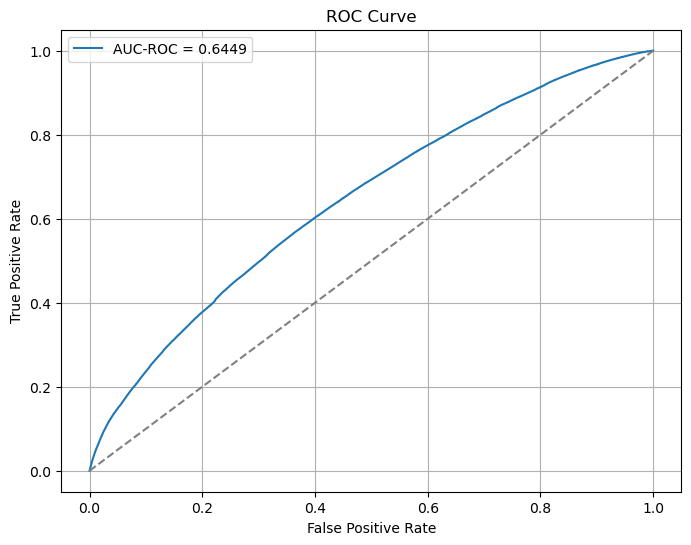

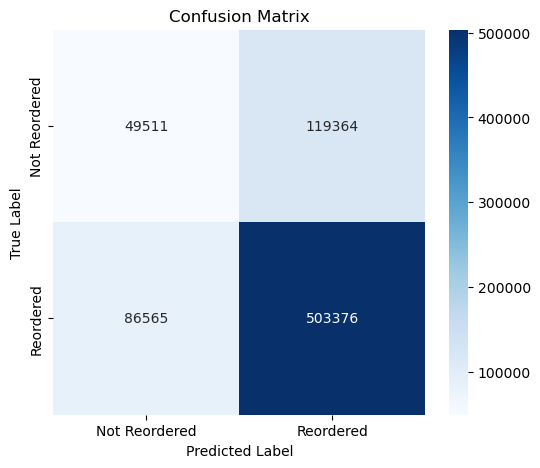

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

# Load the test dataset
test_data_path = "s3://sagemaker-us-east-1-921916832724/Project/test_data_transformed_mapped.csv"  # Update if needed
df_test = pd.read_csv(test_data_path)

# Keep `department_category` for later analysis
df_test_original = df_test.copy()  # Store original data with department_category
department_category = df_test_original["department_category"]  # Extract the column

# Separate features and labels
X_test = df_test.drop(columns=["reordered", "department_category"])  # Remove target & category
y_test = df_test["reordered"]

# Convert to DMatrix format (required for XGBoost)
dtest = xgb.DMatrix(X_test)

# Make Predictions
y_pred_probs = xgb_model.predict(dtest)
y_pred = np.where(y_pred_probs > 0.5, 1, 0)  # Convert probabilities to binary class (Threshold = 0.5)

# Add Predictions Back to Original Data
df_test_original["predicted_label"] = y_pred
df_test_original["predicted_probability"] = y_pred_probs

# Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_probs)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print Evaluation Metrics
print(f" Model Evaluation Results:")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1-score: {f1:.4f}")
print(f" AUC-ROC: {auc_roc:.4f}")
print(" Confusion Matrix:")
print(conf_matrix)

#  AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC = {auc_roc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

#  Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Reordered", "Reordered"], yticklabels=["Not Reordered", "Reordered"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import pandas as pd
import boto3

# S3 bucket details
bucket_name = "sagemaker-us-east-1-921916832724"
s3_key = "Project/test_data_transformed_mapped.csv"
local_file_path = "test_data_transformed_mapped_no_headers.csv"

#  Read CSV from S3 using s3fs
df = pd.read_csv(f"s3://{bucket_name}/{s3_key}", storage_options={"anon": False})

#  Drop the headers by saving without header row
df.to_csv(local_file_path, index=False, header=False)

# Upload the updated file back to S3
s3_client = boto3.client("s3")
s3_client.upload_file(local_file_path, bucket_name, "Project/test_data_transformed_mapped_no_headers.csv")

print("Updated file uploaded successfully to S3!")



INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


Updated file uploaded successfully to S3!


In [ ]:
import pandas as pd

#  Define correct column names
columns = ["reordered", "user_id", "product_id", "aisle_id", "department_id_encoded", "department_category"]

#  Load CSV with proper columns
file_path = "s3://sagemaker-us-east-1-921916832724/Project/test_data_transformed_mapped.csv"
df = pd.read_csv(file_path, names=columns, header=None)

#  Drop only the "department_category" column
df = df.drop(columns=["department_category"], errors="ignore")

#  Save without headers (target column included)
cleaned_file_path = "test_data_transformed_mapped_with_target.csv"
df.to_csv(cleaned_file_path, index=False, header=False)

print(" Dataset cleaned and saved with target column:", cleaned_file_path)



INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


 Dataset cleaned and saved with target column: test_data_transformed_mapped_with_target.csv


In [ ]:
print(df.head())

   0         1         2         3         4
0  0 -0.556213  1.639856 -1.640985 -1.130413
1  1 -0.030463  0.753629 -1.640985 -1.130413
2  0 -1.029198 -1.301582 -1.593246 -1.130413
3  0  1.135229 -0.945075 -1.688724 -1.130413
4  1  0.118581 -1.038343  1.652977 -1.130413


In [ ]:
import pandas as pd

#  Load CSV **without headers**
file_path = "s3://sagemaker-us-east-1-921916832724/Project/test_data_transformed_mapped.csv"
df = pd.read_csv(file_path, header=None)

#  Drop only the "department_category" column (last column)
df = df.iloc[:, :-1]  # Drop the last column

#  Save the cleaned dataset without headers
cleaned_file_path = "test_data_transformed_mapped_no_headers.csv"
df.to_csv(cleaned_file_path, index=False, header=False)

print(" Dataset cleaned and saved without headers:", cleaned_file_path)


INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


 Dataset cleaned and saved without headers: test_data_transformed_mapped_no_headers.csv


In [ ]:
import boto3

s3_client = boto3.client("s3")
s3_bucket = "sagemaker-us-east-1-921916832724"
s3_key = "Project/test_data_transformed_mapped_no_headers.csv"

s3_client.upload_file(cleaned_file_path, s3_bucket, s3_key)

print(" Updated dataset uploaded to S3:", f"s3://{s3_bucket}/{s3_key}")


 Updated dataset uploaded to S3: s3://sagemaker-us-east-1-921916832724/Project/test_data_transformed_mapped_no_headers.csv


In [ ]:
from sagemaker.transformer import Transformer

#  Path to the updated dataset in S3
test_data_s3_path = "s3://sagemaker-us-east-1-921916832724/Project/test_data_transformed_mapped_no_headers.csv"

#  Define Transformer
transformer = Transformer(
    model_name="XGBoost-Reorder-Predictions",
    instance_count=1,
    instance_type="ml.m5.large",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path="s3://sagemaker-us-east-1-921916832724/Project/BatchInferenceResults/",
    accept="text/csv"
)

#  Execute Batch Transform Job
transformer.transform(
    data=test_data_s3_path,
    split_type="Line",
    content_type="text/csv",
    input_filter="$[1:]",  # 
    join_source="Input"
)

#  Wait for job completion
transformer.wait()

print(" Batch inference job completed successfully!")



INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2025-02-19-05-44-58-577


............................/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-02-19:05:49:36:INFO] No GPUs detected (normal if no gpus installed)
[2025-02-19:05:49:36:INFO] No GPUs detected (normal if no gpus installed)
[2025-02-19:05:49:36:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_

# Sage Clarify Explainability Model

In [ ]:
import boto3

s3_client = boto3.client("s3")
s3_bucket = "sagemaker-us-east-1-921916832724"
s3_prefix = "Project/BatchInferenceResults/"

response = s3_client.list_objects_v2(Bucket=s3_bucket, Prefix=s3_prefix)

print(" Files in Batch Inference Output:")
for obj in response.get("Contents", []):
    print(obj["Key"])


 Files in Batch Inference Output:
Project/BatchInferenceResults/test_data_transformed_mapped_no_headers.csv.out


In [ ]:
output_file = "test_data_predictions.csv"
s3_client.download_file(s3_bucket, "Project/BatchInferenceResults/test_data_transformed_mapped_no_headers.csv.out", output_file)

# Load the results
import pandas as pd
df_predictions = pd.read_csv(output_file, header=None)

print(" First 5 predictions:")
print(df_predictions.head())


INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sh

 First 5 predictions:
   0         1         2         3         4         5
0  0 -0.556213  1.639856 -1.640985 -1.130413  0.646163
1  1 -0.030463  0.753629 -1.640985 -1.130413  0.623215
2  0 -1.029198 -1.301582 -1.593246 -1.130413  0.581318
3  0  1.135229 -0.945075 -1.688724 -1.130413  0.633384
4  1  0.118581 -1.038343  1.652977 -1.130413  0.530998


In [ ]:
import pandas as pd
import boto3

#  **Define Expected Headers**
headers = ["reordered", "user_id", "product_id", "aisle_id", "department_id_encoded", "probability"]

#  **S3 Paths**
s3_bucket = "sagemaker-us-east-1-921916832724"
s3_input_path = "Project/BatchInferenceResults/test_data_transformed_mapped_no_headers.csv.out"
s3_output_path = "Project/BatchInferenceResults/test_data_transformed_mapped_with_headers.csv"

#  **Download the File from S3**
s3_client = boto3.client("s3")
local_file = "test_data_transformed_mapped_no_headers.csv.out"
updated_file = "test_data_transformed_mapped_with_headers.csv"

s3_client.download_file(s3_bucket, s3_input_path, local_file)

#  **Load CSV Without Headers**
df = pd.read_csv(local_file, header=None)

#  **Assign Correct Headers**
df.columns = headers

#  **Save File with Headers**
df.to_csv(updated_file, index=False, header=True)

#  **Upload Back to S3**
s3_client.upload_file(updated_file, s3_bucket, s3_output_path)

print(f" Updated File Uploaded: s3://{s3_bucket}/{s3_output_path}")


INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sh

 Updated File Uploaded: s3://sagemaker-us-east-1-921916832724/Project/BatchInferenceResults/test_data_transformed_mapped_with_headers.csv


In [ ]:
import pandas as pd
df = pd.read_csv("test_data_transformed_mapped_with_headers.csv")
print(df["department_id_encoded"].unique())


[-1.13041252 -0.40084007  0.6935186   1.05830482  1.78787727 -0.03605385
 -1.49519874  0.32873238 -0.7656263   1.42309105]


In [ ]:
import pandas as pd

# Load dataset (Replace with actual S3 path)
df = pd.read_csv("s3://sagemaker-us-east-1-921916832724/Project/BatchInferenceResults/test_data_transformed_mapped_fixed.csv")

# Display first few rows
print(df.head())


INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


   reordered   user_id  product_id  aisle_id  department_id_encoded
0          0 -0.556213    1.639856 -1.640985              -1.130413
1          1 -0.030463    0.753629 -1.640985              -1.130413
2          0 -1.029198   -1.301582 -1.593246              -1.130413
3          0  1.135229   -0.945075 -1.688724              -1.130413
4          1  0.118581   -1.038343  1.652977              -1.130413


In [ ]:
# Import Required Libraries
import boto3
import sagemaker
from sagemaker import Session
from sagemaker.s3 import S3Downloader, S3Uploader
from sagemaker.clarify import DataConfig, ModelConfig, SHAPConfig, SageMakerClarifyProcessor

# Initialize SageMaker Session
session = Session()
role = sagemaker.get_execution_role()
region = session.boto_region_name

# Define S3 Bucket and Prefix for the Project
bucket = "sagemaker-us-east-1-921916832724"
prefix = "Project"

# Define S3 Paths for Explainability
s3_data_path = f"s3://{bucket}/{prefix}/BatchInferenceResults/test_data_transformed_mapped_fixed.csv"  
s3_output_path = f"s3://{bucket}/{prefix}/explainability_output"

# Define Data Config for Clarify
data_config = DataConfig(
    s3_data_input_path=s3_data_path,  # Use the correct dataset without headers
    s3_output_path=s3_output_path,
    label="reordered",  # Target column
    headers=["reordered", "user_id", "product_id", "aisle_id", "department_id_encoded"],  
    dataset_type="text/csv"
)

print(" Data Config Set!")

# Define Model Config
model_config = ModelConfig(
    model_name="XGBoost-Reorder-Predictions",  # Trained XGBoost Model in SageMaker
    instance_type="ml.m5.xlarge",
    instance_count=1,
    content_type="text/csv",
    accept_type="text/csv"
)

print(" Model Config Set!")

# Define SHAP (Explainability) Config
shap_config = SHAPConfig(
    baseline=[[-1, -1, -1, -1]],  # Dummy baseline (adjust as needed)
    num_samples=50,  # Number of samples to use for SHAP
    agg_method="mean_abs",
    save_local_shap_values=True  # Save detailed SHAP values
)

print(" SHAP Config Set!")

# Initialize SageMaker Clarify Processor
clarify_processor = SageMakerClarifyProcessor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    sagemaker_session=session
)

print(" Clarify Processor Initialized!")

# Run Explainability Job
clarify_processor.run_explainability(
    data_config=data_config,
    model_config=model_config,
    explainability_config=shap_config
)

print(f" Explainability Job Started! Results will be saved to: {s3_output_path}")


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['reordered', 'user_id', 'product_id', 'aisle_id', 'department_id_encoded'], 'label': 'reordered', 'predictor': {'model_name': 'XGBoost-Reorder-Predictions', 'instance_type': 'ml.m5.xlarge', 'initial_instance_count': 1, 'accept_type': 'text/csv', 'content_type': 'text/csv'}, 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'shap': {'use_logit': False, 'save_local_shap_values': True, 'baseline': [[-1, -1, -1, -1]], 'num_samples': 50, 'agg_method': 'mean_abs'}}}
INFO:sagemaker:Creating processing-job with name Clarify-Explainability-2025-02-20-04-01-11-107


 Data Config Set!
 Model Config Set!
 SHAP Config Set!
 Clarify Processor Initialized!
...................sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
We are not in a supported iso region, /bin/sh exiting gracefully with no changes.
INFO:sagemaker-clarify-processing:Starting SageMaker Clarify Processing job
INFO:analyzer.data_loading.data_loader_util:Analysis config path: /opt/ml/processing/input/config/analysis_config.json
INFO:analyzer.data_loading.data_loader_util:Analysis result path: /opt/ml/processing/output
INFO:analyzer.data_loading.data_loader_util:This host is algo-1.
INFO:analyzer.data_loading.data_loader_util:This host is the leader.
INFO:analyzer.data_loading.data_loader_util:Number of hosts in the cluster is 1.
INFO:sagemaker-clarify-processing:Running Python / Pandas based analyzer.
INFO:analyzer.data_loading.data_loader_

In [ ]:
!pip install shap

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sh

 SHAP output file downloaded: /tmp/shap_out.csv
 First few rows of SHAP explanations:
   user_id_label0  product_id_label0  aisle_id_label0  \
0        0.021831          -0.014603         0.087960   
1       -0.000151           0.010152         0.062239   
2        0.000000           0.102718        -0.072375   
3        0.007305           0.000422         0.074682   
4        0.001652           0.024161        -0.045789   

   department_id_encoded_label0  
0                           0.0  
1                           0.0  
2                           0.0  
3                           0.0  
4                           0.0  


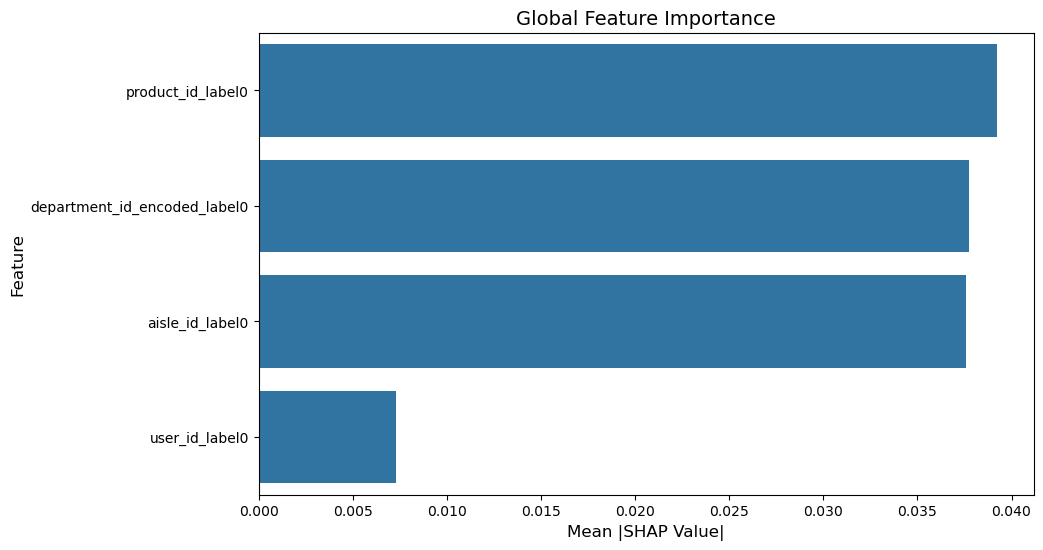

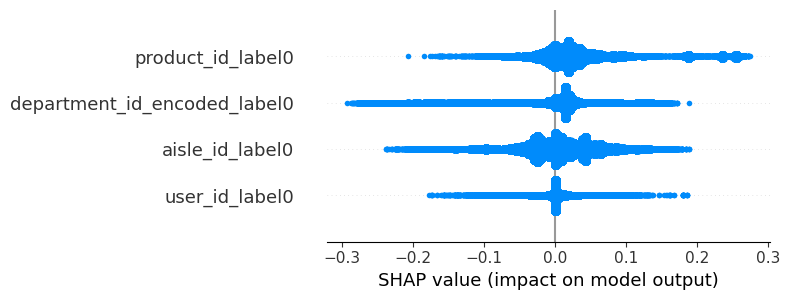

In [ ]:
import boto3
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define S3 parameters
bucket_name = "sagemaker-us-east-1-921916832724"
s3_prefix = "Project/explainability_output"
s3_file_name = "explanations_shap/out.csv"  # SHAP output file

# Local path to save the SHAP file
local_shap_file = "/tmp/shap_out.csv"

# Initialize S3 client
s3_client = boto3.client("s3")

# Download SHAP output from S3
s3_client.download_file(bucket_name, f"{s3_prefix}/{s3_file_name}", local_shap_file)
print(f" SHAP output file downloaded: {local_shap_file}")

# Load SHAP values into Pandas DataFrame
shap_df = pd.read_csv(local_shap_file)

# Display the first few rows
print(" First few rows of SHAP explanations:")
print(shap_df.head())

# -------------------------
#  GLOBAL FEATURE IMPORTANCE
# -------------------------
plt.figure(figsize=(10, 6))
shap_values_mean = shap_df.abs().mean().sort_values(ascending=False)
sns.barplot(x=shap_values_mean.values, y=shap_values_mean.index)
plt.xlabel("Mean |SHAP Value|", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Global Feature Importance", fontsize=14)
plt.show()

# -------------------------
#  SHAP SUMMARY PLOT (Without Explainer)
# -------------------------
shap_values_np = shap_df.values

shap.summary_plot(shap_values_np, feature_names=shap_df.columns)



- **Global Feature Importance (First Image)**

    - The product_id has the highest importance, meaning it has the most influence on whether a product is reordered.
    - Department ID and Aisle ID also play significant roles.
    - User ID has the least importance in the prediction.

- **SHAP Summary Plot (Second Image)**

    - Each dot represents a SHAP value for an instance in the dataset.
    - A positive SHAP value means the feature increases the prediction probability.
    - A negative SHAP value decreases the probability of a product being reordered.
    - The spread of dots indicates how much variability a feature has in affecting the model's prediction.

##  Zoom in on a specific feature (product_id)

In [ ]:
import boto3
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Load SHAP values
shap_values = pd.read_csv("s3://sagemaker-us-east-1-921916832724/Project/explainability_output/explanations_shap/out.csv")  # Update with your actual path
features = shap_values.columns[:-1]  # Excluding label

# Load the original dataset (if needed)
data = pd.read_csv("s3://sagemaker-us-east-1-921916832724/Project/test_data_transformed_mapped.csv")  # Update with actual path



In [ ]:
print(data.columns)


Index(['reordered', 'user_id', 'product_id', 'aisle_id',
       'department_id_encoded', 'department_category'],
      dtype='object')


In [ ]:
print(shap_values.columns)


Index(['user_id_label0', 'product_id_label0', 'aisle_id_label0',
       'department_id_encoded_label0'],
      dtype='object')


In [ ]:
# Strip "_label0" suffix from SHAP feature names
shap_values.columns = [col.replace("_label0", "") for col in shap_values.columns]



In [ ]:
print(shap_values.columns)

Index(['user_id', 'product_id', 'aisle_id', 'department_id_encoded'], dtype='object')


In [ ]:
print("Shape of shap_values:", shap_values.shape)  # Should be (rows, 4)
print("Shape of data:", data.shape)  # Should be (rows, 4)


Shape of shap_values: (758816, 4)
Shape of data: (758816, 6)


In [ ]:
# Drop the extra column 'reordered' from data
data_filtered = data.drop(columns=["reordered"])

# Print shapes to confirm they match
print("Shape of shap_values:", shap_values.shape)  # Should be (758816, 4)
print("Shape of data_filtered:", data_filtered.shape)  # Should be (758816, 4)

# Ensure column names match
print("SHAP Columns:", shap_values.columns)
print("Data Columns:", data_filtered.columns)


Shape of shap_values: (758816, 4)
Shape of data_filtered: (758816, 5)
SHAP Columns: Index(['user_id', 'product_id', 'aisle_id', 'department_id_encoded'], dtype='object')
Data Columns: Index(['user_id', 'product_id', 'aisle_id', 'department_id_encoded',
       'department_category'],
      dtype='object')


In [ ]:
import pandas as pd
import numpy as np

# Compute mean absolute SHAP values per feature
shap_importance = np.abs(shap_values).mean(axis=0)

# Find the most influential product_id based on its SHAP value
most_influential_product_index = shap_importance.argmax()

# Print the most influential product ID
most_influential_product_id = data_filtered["product_id"].iloc[most_influential_product_index]
print("Most influential product ID:", most_influential_product_id)


Most influential product ID: 0.7536288861882413


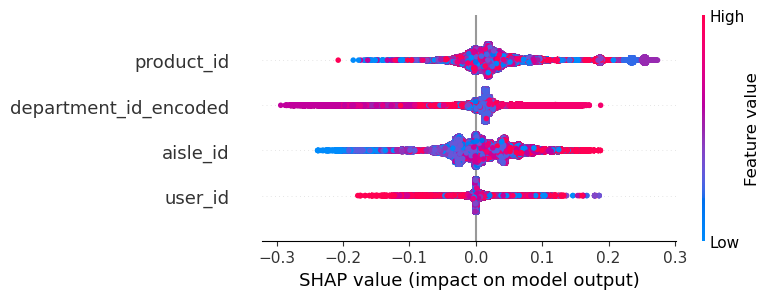

In [ ]:
import shap
import matplotlib.pyplot as plt

# Convert department_category to categorical values for color mapping
data_filtered['department_category'] = data_filtered['department_category'].astype('category')

# Create color mapping for categories
category_colors = dict(zip(data_filtered['department_category'].cat.categories, range(len(data_filtered['department_category'].cat.categories))))

# Map the department_category column to numerical values for coloring
color_values = data_filtered['department_category'].map(category_colors)

# Generate the SHAP summary plot
shap.summary_plot(shap_values.values, data_filtered[shap_values.columns], plot_type="dot", color=color_values)

# Show the plot
plt.show()


/tmp/ipykernel_9658/4004629923.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_shap_per_category = shap_df.groupby('department_category').mean().abs().sum(axis=1)


Most Influential Department Category: baking supplies decor


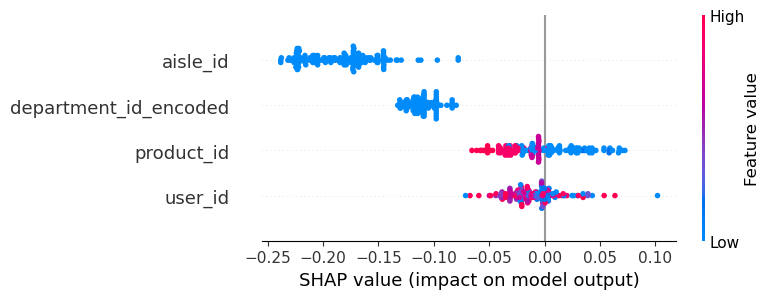

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Compute mean absolute SHAP values grouped by department_category
shap_df = pd.DataFrame(shap_values.values, columns=shap_values.columns)
shap_df['department_category'] = data_filtered['department_category']

# Compute mean SHAP values for each category
mean_shap_per_category = shap_df.groupby('department_category').mean().abs().sum(axis=1)

# Identify the most influential department_category
most_influential_category = mean_shap_per_category.idxmax()
print(f"Most Influential Department Category: {most_influential_category}")

# Filter data for only the most influential category
filtered_data = data_filtered[data_filtered['department_category'] == most_influential_category]
filtered_shap_values = shap_values.values[data_filtered['department_category'] == most_influential_category]

# Generate SHAP summary plot for the most influential category
shap.summary_plot(filtered_shap_values, filtered_data[shap_values.columns])

# Show plot
plt.show()


/tmp/ipykernel_9658/611016332.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_shap_per_category = shap_df.groupby('department_category').mean().abs().sum(axis=1)


Top 10 Most Influential Department Categories:
 department_category
baking supplies decor         0.308901
spices seasonings             0.302714
baking ingredients            0.264407
condiments                    0.258203
preserved dips spreads        0.239960
ice cream toppings            0.238668
salad dressing toppings       0.238339
doughs gelatins bake mixes    0.230489
pickled goods olives          0.225684
milk                          0.223928
dtype: float64


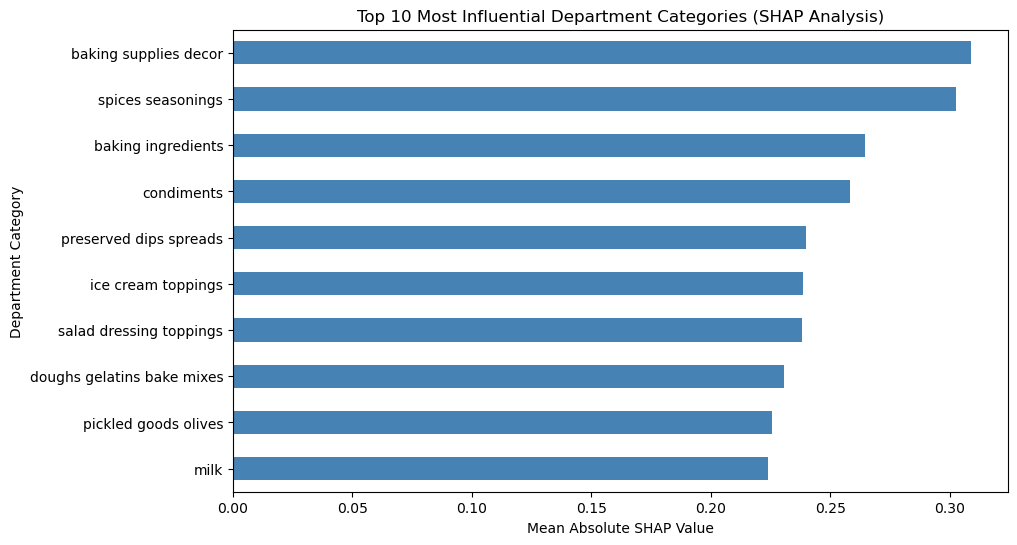

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Compute mean absolute SHAP values grouped by department_category
shap_df = pd.DataFrame(shap_values.values, columns=shap_values.columns)
shap_df['department_category'] = data_filtered['department_category']

# Compute mean SHAP values for each category
mean_shap_per_category = shap_df.groupby('department_category').mean().abs().sum(axis=1)

# Get the top 10 most influential categories
top_10_categories = mean_shap_per_category.sort_values(ascending=False).head(10)

# Print the top 10 influential categories
print("Top 10 Most Influential Department Categories:\n", top_10_categories)

# Plot the top 10 categories
plt.figure(figsize=(10, 6))
top_10_categories.plot(kind='barh', color='steelblue')
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Department Category")
plt.title("Top 10 Most Influential Department Categories (SHAP Analysis)")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()


/tmp/ipykernel_9658/2943673365.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_shap_per_category = shap_df.groupby('department_category').mean().abs().sum(axis=1)


10 Least Influential Department Categories:
 department_category
fruit vegetable snacks           0.016005
other creams cheeses             0.018015
frozen juice                     0.019774
frozen breakfast                 0.028485
packaged cheese                  0.028575
soft drinks                      0.033737
refrigerated pudding desserts    0.034210
frozen meals                     0.040212
frozen appetizers sides          0.043123
juice nectars                    0.045113
dtype: float64


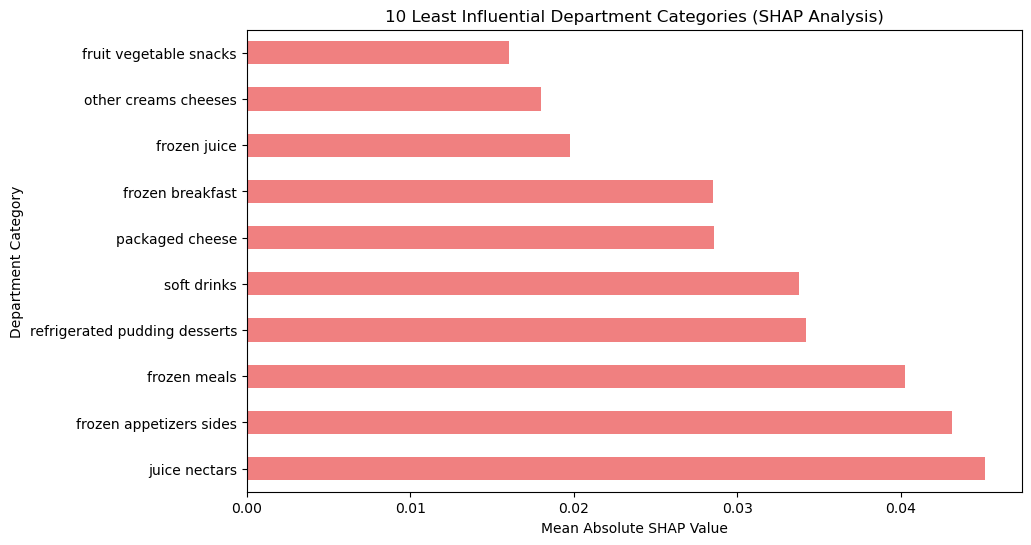

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Compute mean absolute SHAP values grouped by department_category
shap_df = pd.DataFrame(shap_values.values, columns=shap_values.columns)
shap_df['department_category'] = data_filtered['department_category']

# Compute mean SHAP values for each category
mean_shap_per_category = shap_df.groupby('department_category').mean().abs().sum(axis=1)

# Get the 10 least influential categories
bottom_10_categories = mean_shap_per_category.sort_values(ascending=True).head(10)

# Print the 10 least influential categories
print("10 Least Influential Department Categories:\n", bottom_10_categories)

# Plot the bottom 10 categories
plt.figure(figsize=(10, 6))
bottom_10_categories.plot(kind='barh', color='lightcoral')
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Department Category")
plt.title("10 Least Influential Department Categories (SHAP Analysis)")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()


In [ ]:
data = pd.read_csv("s3://sagemaker-us-east-1-921916832724/Project/test_data_transformed_mapped.csv")

In [ ]:
# Ensure 'reordered' exists in data before adding it
if 'reordered' in data.columns:
    data_filtered['reordered'] = data['reordered']
    print("Successfully added 'reordered' column to data_filtered!")
else:
    print("Error: 'reordered' column not found in data!")


Successfully added 'reordered' column to data_filtered!


/tmp/ipykernel_9658/3089370894.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('department_category')


Top 10 Department Categories Influencing Reorders:
 department_category
spices seasonings             1.302833
baking supplies decor         1.286841
baking ingredients            1.254694
condiments                    1.254094
ice cream toppings            1.240485
preserved dips spreads        1.240431
salad dressing toppings       1.235963
doughs gelatins bake mixes    1.232503
milk                          1.225567
pickled goods olives          1.223242
dtype: float64


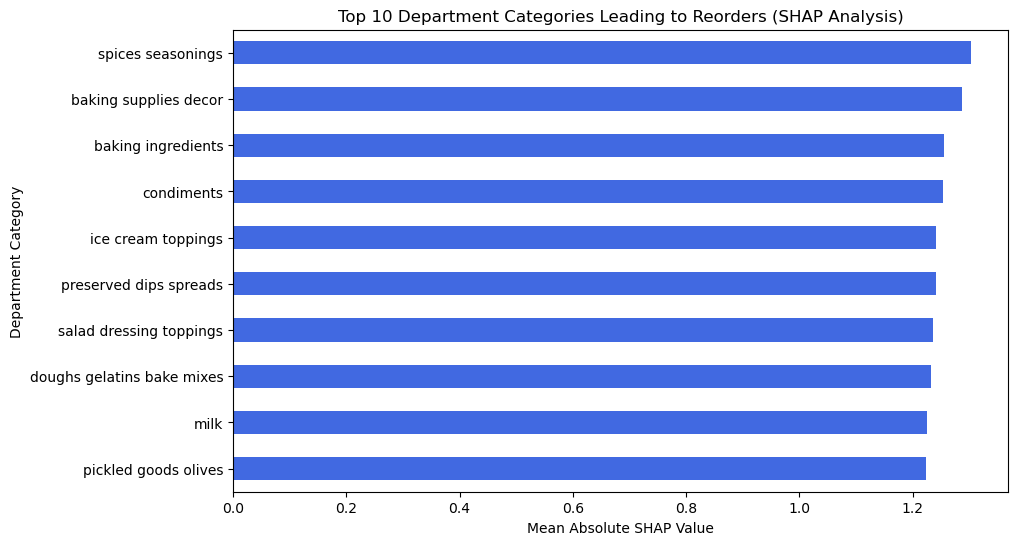

In [ ]:
# Compute mean absolute SHAP values grouped by department_category
shap_df = pd.DataFrame(shap_values.values, columns=shap_values.columns)
shap_df['department_category'] = data_filtered['department_category']
shap_df['reordered'] = data_filtered['reordered']  # Add reordered column

# Compute mean SHAP values for each category where reordered = 1 (reorders)
mean_shap_per_category_reordered = (
    shap_df[shap_df['reordered'] == 1]  # Filter only reordered entries
    .groupby('department_category')
    .mean()
    .abs()
    .sum(axis=1)  # Sum SHAP values for all features
)

# Get the top 10 most influential categories leading to reorders
top_10_reordered_categories = mean_shap_per_category_reordered.sort_values(ascending=False).head(10)

# Print the 10 most influential department categories for reorders
print("Top 10 Department Categories Influencing Reorders:\n", top_10_reordered_categories)

# Plot the top 10 department categories
plt.figure(figsize=(10, 6))
top_10_reordered_categories.plot(kind='barh', color='royalblue')
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Department Category")
plt.title("Top 10 Department Categories Leading to Reorders (SHAP Analysis)")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

In [ ]:
# Filter dataset for products that WERE reordered
reordered_data = data_filtered[data_filtered['reordered'] == 1]

# Compute the SHAP influence for each product_id in reordered cases
shap_reordered = shap_values.values[data_filtered['reordered'] == 1]

# Create a DataFrame to hold SHAP values for each product
shap_reordered_df = pd.DataFrame(shap_reordered, columns=shap_values.columns)
shap_reordered_df['product_id'] = reordered_data['product_id'].values

# Aggregate SHAP values for each product
shap_product_reordered = shap_reordered_df.groupby('product_id').mean().abs().sum(axis=1)

# Get the **10 most influential products** for reordering
top_10_most_influential_products = shap_product_reordered.nlargest(10)

# Display results
print("Top 10 Most Influential Products for Reordering:")
print(top_10_most_influential_products)


Top 10 Most Influential Products for Reordering:
product_id
 0.719347    0.357303
-1.308928    0.342568
-1.842177    0.332636
-0.974892    0.327255
-1.852260    0.325282
-0.701569    0.324777
-1.374396    0.318342
 1.541690    0.316993
 1.297321    0.316877
-1.158835    0.315992
dtype: float64


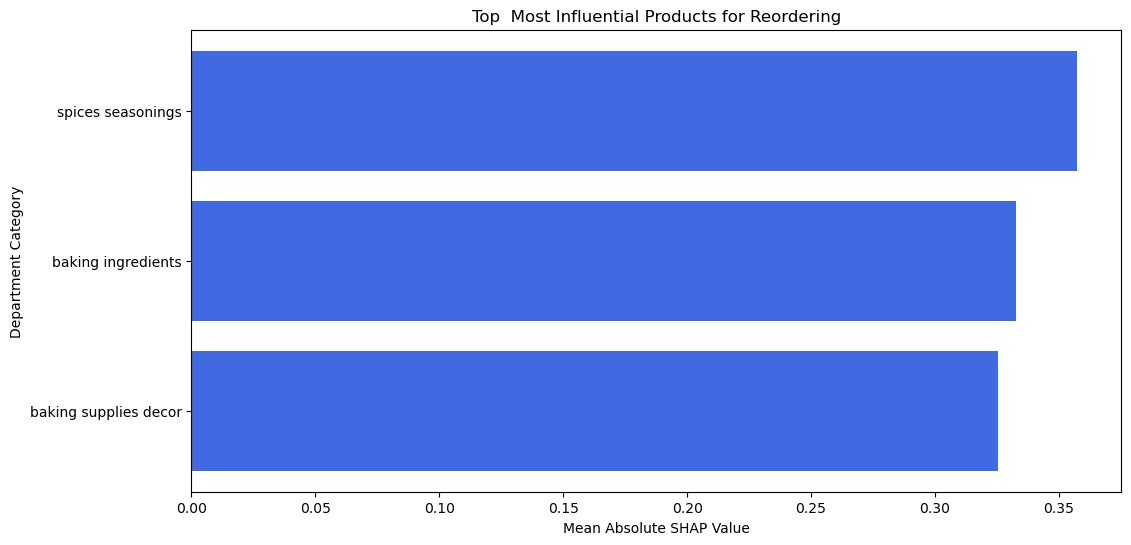

In [ ]:
import matplotlib.pyplot as plt

# Get the department category for each product in the most influential list
most_influential_products_df = top_10_most_influential_products.reset_index()
most_influential_products_df = most_influential_products_df.merge(
    data_filtered[['product_id', 'department_category']], 
    on='product_id', 
    how='left'
).drop_duplicates()

# Plot the results
plt.figure(figsize=(12, 6))
plt.barh(most_influential_products_df['department_category'], most_influential_products_df.iloc[:, 1], color='royalblue')

plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Department Category")
plt.title("Top  Most Influential Products for Reordering")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization

plt.show()



In [ ]:
# Filter dataset for products that were NOT reordered
not_reordered_data = data_filtered[data_filtered['reordered'] == 0]

# Compute the SHAP influence for each product_id
shap_not_reordered = shap_values.values[data_filtered['reordered'] == 0]

# Create a DataFrame to hold SHAP values for each product
shap_not_reordered_df = pd.DataFrame(shap_not_reordered, columns=shap_values.columns)
shap_not_reordered_df['product_id'] = not_reordered_data['product_id'].values

# Aggregate SHAP values for each product
shap_product_not_reordered = shap_not_reordered_df.groupby('product_id').mean().abs().sum(axis=1)

# Get the 10 products with the **lowest** SHAP impact (least influential for reordering)
least_influential_products = shap_product_not_reordered.nsmallest(10)

# Display the result
print("Top 10 Products Least Likely to Be Not Reordered:")
print(least_influential_products)


Top 10 Products Least Likely to Be Not Reordered:
product_id
 0.925905    0.000811
 0.481891    0.002422
 1.117194    0.002469
 1.288462    0.002594
 1.288750    0.002765
 1.483713    0.002766
 1.589873    0.003125
-1.597807    0.003167
 0.932603    0.003323
-1.472130    0.003582
dtype: float64


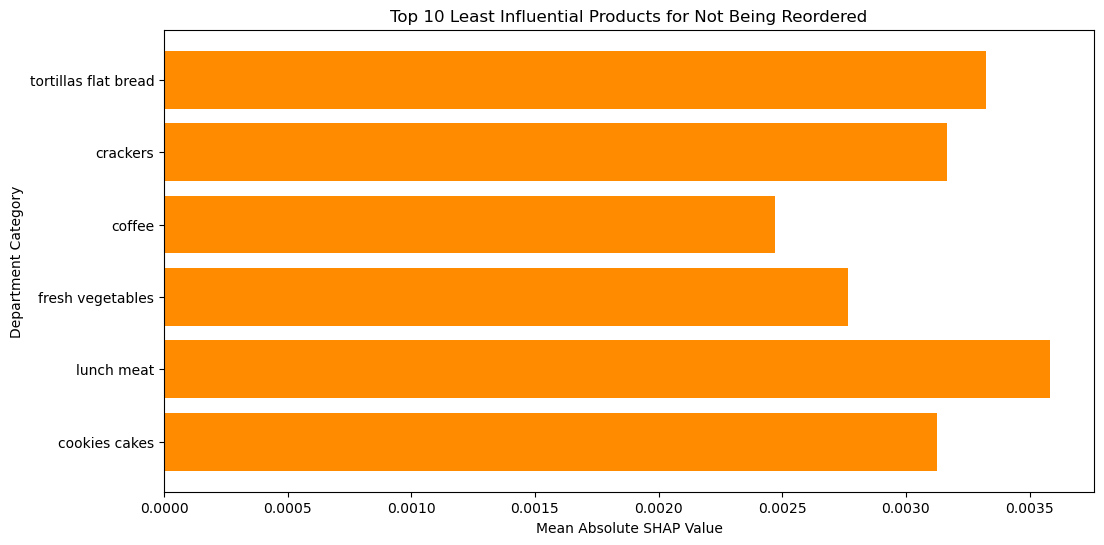

In [ ]:
import matplotlib.pyplot as plt

# Get the department category for each product in the least influential list
least_influential_products_df = least_influential_products.reset_index()
least_influential_products_df = least_influential_products_df.merge(
    data_filtered[['product_id', 'department_category']], 
    on='product_id', 
    how='left'
).drop_duplicates()

# Plot the results
plt.figure(figsize=(12, 6))
plt.barh(least_influential_products_df['department_category'], least_influential_products_df.iloc[:, 1], color='darkorange')

plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Department Category")
plt.title("Top 10 Least Influential Products for Not Being Reordered")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization

plt.show()


/tmp/ipykernel_9658/605473766.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('department_category')


Top 10 Department Categories Influencing Not Reorders:
 department_category
baking supplies decor         0.320447
spices seasonings             0.302612
baking ingredients            0.276365
condiments                    0.262277
salad dressing toppings       0.240797
ice cream toppings            0.239312
preserved dips spreads        0.239014
pickled goods olives          0.229954
doughs gelatins bake mixes    0.226888
marinades meat preparation    0.223012
dtype: float64


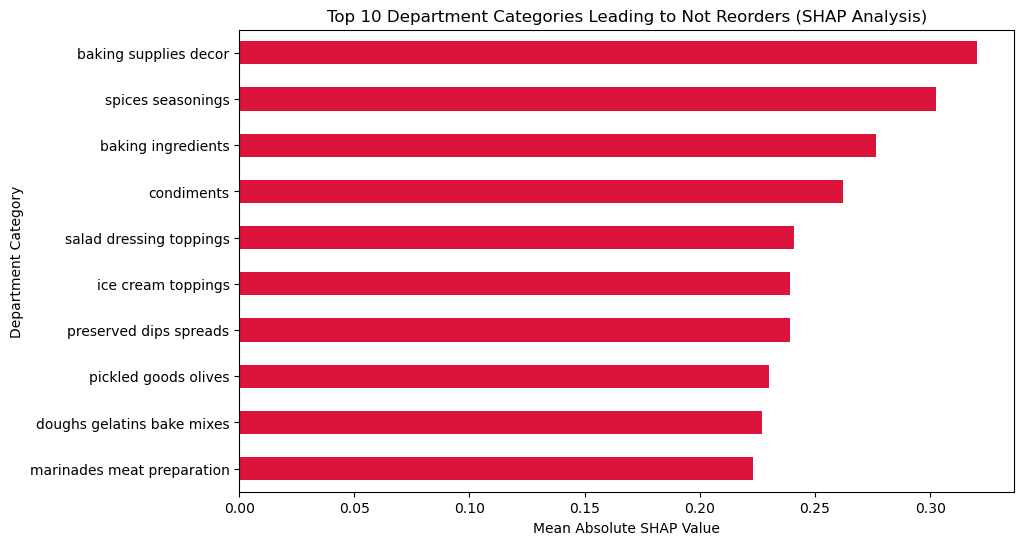

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Ensure 'reordered' is in the dataset
if 'reordered' not in data_filtered.columns:
    print("Warning: 'reordered' column not found in dataset.")

# Compute mean absolute SHAP values grouped by department_category
shap_df = pd.DataFrame(shap_values.values, columns=shap_values.columns)
shap_df['department_category'] = data_filtered['department_category']
shap_df['reordered'] = data_filtered['reordered']  # Add reordered column

# Compute mean SHAP values for each category where reordered = 0 (not reorders)
mean_shap_per_category_not_reordered = (
    shap_df[shap_df['reordered'] == 0]  # Filter only non-reordered entries
    .groupby('department_category')
    .mean()
    .abs()
    .sum(axis=1)  # Sum SHAP values for all features
)

# Get the top 10 most influential categories leading to not reorders
top_10_not_reordered_categories = mean_shap_per_category_not_reordered.sort_values(ascending=False).head(10)

# Print the 10 most influential department categories for not reorders
print("Top 10 Department Categories Influencing Not Reorders:\n", top_10_not_reordered_categories)

# Plot the top 10 department categories
plt.figure(figsize=(10, 6))
top_10_not_reordered_categories.plot(kind='barh', color='crimson')
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Department Category")
plt.title("Top 10 Department Categories Leading to Not Reorders (SHAP Analysis)")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()


**Summary of SHAP Analysis on Reordering Behavior**:


1. General Feature Importance
    - Product ID has the highest impact on reorder predictions, followed by Department ID (Encoded), Aisle ID, and User ID.
    - The most influential feature suggests that the specific products and their respective department associations play a significant role in predicting reordering behavior.

2. Most Influential Department Categories
    - The top department categories driving reordering behavior include:
        - Spices & Seasonings
        - Baking Supplies & Decor
        - Baking Ingredients
        - Condiments
        - Ice Cream Toppings
        - Preserved Dips & Spreads
        - Salad Dressing Toppings
        - Doughs, Gelatins & Bake Mixes
        - Milk
        - Pickled Goods & Olives

These categories typically consist of frequently used ingredients and perishables, which explains their likelihood of being reordered.

3. Least Influential Department Categories
    - The department categories with the least impact on reorder likelihood include:
        - Fruit & Vegetable Snacks
        - Other Creams & Cheeses
        - Frozen Juice
        - Frozen Breakfast
        - Packaged Cheese
        - Soft Drinks
        - Refrigerated Pudding & Desserts
        - Frozen Meals
        - Frozen Appetizers & Sides
        - Juice Nectars
These categories may not be reordered frequently due to longer shelf life or sporadic purchase habits.

4. Most Influential Products for Reordering
    - The top individual products contributing to reorder likelihood are mapped to the following department categories:

        - Spices & Seasonings
        - Baking Ingredients
        - Baking Supplies & Decor
This reinforces the trend that frequently used ingredients are strong predictors of repeat purchases.

5. Least Influential Products for Reordering
    - The least impactful products (not likely to be reordered) belong to:
        - Tortillas & Flat Bread
        - Crackers
        - Coffee
        - Fresh Vegetables
        - Lunch Meat
        - Cookies & Cakes
These products might be purchased in bulk, have longer consumption cycles, or are purchased occasionally.

**Conclusion**
The analysis successfully identified which product categories and specific products strongly drive reordering behavior.
The most frequently reordered items tend to be core ingredients and consumables, while packaged, frozen, and impulse-purchase items are less likely to be reordered.
The insights from this analysis can help businesses optimize inventory management, personalized recommendations, and customer retention strategies.

# CI/CD Pipelines

## Orchestrate Jobs to Train and Evaluate Models with Amazon SageMaker Pipelines



Amazon SageMaker Pipelines offers machine learning (ML) application developers and operations engineers the ability to orchestrate SageMaker jobs and author reproducible ML pipelines. It also enables them to deploy custom-built models for inference in real-time with low latency, run offline inferences with Batch Transform, and track lineage of artifacts. They can institute sound operational practices in deploying and monitoring production workflows, deploying model artifacts, and tracking artifact lineage through a simple interface, adhering to safety and best practice paradigms for ML application development.

The SageMaker Pipelines service supports a SageMaker Pipeline domain specific language (DSL), which is a declarative JSON specification. This DSL defines a directed acyclic graph (DAG) of pipeline parameters and SageMaker job steps. The SageMaker Python Software Developer Kit (SDK) streamlines the generation of the pipeline DSL using constructs that engineers and scientists are already familiar with.

## Runtime

This notebook takes approximately an hour to run.

## Contents

1. [SageMaker Pipelines](#SageMaker-Pipelines)
1. [Notebook Overview](#Notebook-Overview)
1. [A SageMaker Pipeline](#A-SageMaker-Pipeline)
1. [Dataset](#Dataset)
1. [Define Parameters to Parametrize Pipeline Execution](#Define-Parameters-to-Parametrize-Pipeline-Execution)
1. [Define a Processing Step for Feature Engineering](#Define-a-Processing-Step-for-Feature-Engineering)
1. [Define a Training Step to Train a Model](#Define-a-Training-Step-to-Train-a-Model)
1. [Define a Model Evaluation Step to Evaluate the Trained Model](#Define-a-Model-Evaluation-Step-to-Evaluate-the-Trained-Model)
1. [Define a Create Model Step to Create a Model](#Define-a-Create-Model-Step-to-Create-a-Model)
1. [Define a Transform Step to Perform Batch Transformation](#Define-a-Transform-Step-to-Perform-Batch-Transformation)
1. [Define a Register Model Step to Create a Model Package](#Define-a-Register-Model-Step-to-Create-a-Model-Package)
1. [Define a Fail Step to Terminate the Pipeline Execution and Mark it as Failed](#Define-a-Fail-Step-to-Terminate-the-Pipeline-Execution-and-Mark-it-as-Failed)
1. [Define a Condition Step to Check Accuracy and Conditionally Create a Model and Run a Batch Transformation and Register a Model in the Model Registry, Or Terminate the Execution in Failed State](#Define-a-Condition-Step-to-Check-Accuracy-and-Conditionally-Create-a-Model-and-Run-a-Batch-Transformation-and-Register-a-Model-in-the-Model-Registry,-Or-Terminate-the-Execution-in-Failed-State)
1. [Define a Pipeline of Parameters, Steps, and Conditions](#Define-a-Pipeline-of-Parameters,-Steps,-and-Conditions)
1. [Submit the pipeline to SageMaker and start execution](#Submit-the-pipeline-to-SageMaker-and-start-execution)
1. [Pipeline Operations: Examining and Waiting for Pipeline Execution](#Pipeline-Operations:-Examining-and-Waiting-for-Pipeline-Execution)
    1. [Examining the Evaluation](#Examining-the-Evaluation)
    1. [Lineage](#Lineage)
    1. [Parametrized Executions](#Parametrized-Executions)

## SageMaker Pipelines

SageMaker Pipelines supports the following activities, which are demonstrated in this notebook:

* Pipelines - A DAG of steps and conditions to orchestrate SageMaker jobs and resource creation.
* Processing job steps - A simplified, managed experience on SageMaker to run data processing workloads, such as feature engineering, data validation, model evaluation, and model interpretation.
* Training job steps - An iterative process that teaches a model to make predictions by presenting examples from a training dataset.
* Conditional execution steps - A step that provides conditional execution of branches in a pipeline.
* Register model steps - A step that creates a model package resource in the Model Registry that can be used to create deployable models in Amazon SageMaker.
* Create model steps - A step that creates a model for use in transform steps or later publication as an endpoint.
* Transform job steps - A batch transform to preprocess datasets to remove noise or bias that interferes with training or inference from a dataset, get inferences from large datasets, and run inference when a persistent endpoint is not needed.
* Fail steps - A step that stops a pipeline execution and marks the pipeline execution as failed.
* Parametrized Pipeline executions - Enables variation in pipeline executions according to specified parameters.

## Notebook Overview

This notebook shows how to:

* Define a set of Pipeline parameters that can be used to parametrize a SageMaker Pipeline.
* Define a Processing step that performs cleaning, feature engineering, and splitting the input data into train and test data sets.
* Define a Training step that trains a model on the preprocessed train data set.
* Define a Processing step that evaluates the trained model's performance on the test dataset.
* Define a Create Model step that creates a model from the model artifacts used in training.
* Define a Transform step that performs batch transformation based on the model that was created.
* Define a Register Model step that creates a model package from the estimator and model artifacts used to train the model.
* Define a Conditional step that measures a condition based on output from prior steps and conditionally executes other steps.
* Define a Fail step with a customized error message indicating the cause of the execution failure.
* Define and create a Pipeline definition in a DAG, with the defined parameters and steps.
* Start a Pipeline execution and wait for execution to complete.
* Download the model evaluation report from the S3 bucket for examination.
* Start a second Pipeline execution.

## A SageMaker Pipeline

The pipeline that you create follows a typical machine learning (ML) application pattern of preprocessing, training, evaluation, model creation, batch transformation, and model registration:

![A typical ML Application pipeline](img/pipeline-full.png)

In [ ]:
!pip install -U sagemaker

  Using cached sagemaker-2.239.3-py3-none-any.whl.metadata (16 kB)
  Using cached sagemaker_core-1.0.24-py3-none-any.whl.metadata (4.9 kB)
  Using cached mock-4.0.3-py3-none-any.whl.metadata (2.8 kB)
Using cached sagemaker-2.239.3-py3-none-any.whl (1.6 MB)
Using cached sagemaker_core-1.0.24-py3-none-any.whl (405 kB)
Using cached mock-4.0.3-py3-none-any.whl (28 kB)
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.228.0
    Uninstalling sagemaker-2.228.0:
      Successfully uninstalled sagemaker-2.228.0


In [ ]:
import sys

import boto3
import sagemaker
from sagemaker.workflow.pipeline_context import PipelineSession

sagemaker_session = sagemaker.session.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()
pipeline_session = PipelineSession()
default_bucket = sagemaker_session.default_bucket()
model_package_group_name = f"InstaCartModelPackageGroupName"

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


Now, upload the data into the default bucket. You can select our own data set for the `input_data_uri` as is appropriate.

In [ ]:
bucket_name = f"sagemaker-example-files-prod-{region}"

In [ ]:
!mkdir -p data

In [ ]:
local_path = "data/02_19_2025_train_data_transformed_mapped.csv"

s3 = boto3.resource("s3")

base_uri = f"s3://{default_bucket}/instacart"
input_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path,
    desired_s3_uri=base_uri,
)
print(input_data_uri)

s3://sagemaker-us-east-1-872137702034/instacart/02_19_2025_train_data_transformed_mapped.csv


Download a second dataset for batch transformation after model creation. You can select our own dataset for the `batch_data_uri` as is appropriate.

In [ ]:
local_path = "data/02_19_2025_production_data_transformed_mapped.csv"

s3 = boto3.resource("s3")

base_uri = f"s3://{default_bucket}/instacart"
batch_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path,
    desired_s3_uri=base_uri,
)
print(batch_data_uri)

s3://sagemaker-us-east-1-872137702034/instacart/02_19_2025_production_data_transformed_mapped.csv


### Define Parameters to Parametrize Pipeline Execution

Define Pipeline parameters that you can use to parametrize the pipeline. Parameters enable custom pipeline executions and schedules without having to modify the Pipeline definition.

The supported parameter types include:

* `ParameterString` - represents a `str` Python type
* `ParameterInteger` - represents an `int` Python type
* `ParameterFloat` - represents a `float` Python type

These parameters support providing a default value, which can be overridden on pipeline execution. The default value specified should be an instance of the type of the parameter.

The parameters defined in this workflow include:

* `processing_instance_count` - The instance count of the processing job.
* `instance_type` - The `ml.*` instance type of the training job.
* `model_approval_status` - The approval status to register with the trained model for CI/CD purposes ("PendingManualApproval" is the default).
* `input_data` - The S3 bucket URI location of the input data.
* `batch_data` - The S3 bucket URI location of the batch data.
* `mse_threshold` - The Mean Squared Error (MSE) threshold used to verify the accuracy of a model.

In [ ]:
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
    ParameterFloat,
)

processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)
instance_type = ParameterString(name="TrainingInstanceType", default_value="ml.m5.xlarge")
model_approval_status = ParameterString(
    name="ModelApprovalStatus", default_value="PendingManualApproval"
)
input_data = ParameterString(
    name="InputData",
    default_value=input_data_uri,
)
batch_data = ParameterString(
    name="BatchData",
    default_value=batch_data_uri,
)
mse_threshold = ParameterFloat(name="MseThreshold", default_value=6.0)

![Define Parameters](img/pipeline-1.png)

### Define a Processing Step for Feature Engineering

First, develop a preprocessing script that is specified in the Processing step.

This notebook cell writes a file `preprocessing.py`, which contains the preprocessing script. You can update the script, and rerun this cell to overwrite. The preprocessing script uses `scikit-learn` to do the following:

* Fill in missing department category data and encode it so that it is suitable for training.
* Scale and normalize all numerical fields, aside from sex and rings numerical data.
* Split the data into training, validation, and test datasets.

The Processing step executes the script on the input data. The Training step uses the preprocessed training features and labels to train a model. The Evaluation step uses the trained model and preprocessed test features and labels to evaluate the model.

In [ ]:
!mkdir -p code

In [ ]:
%%writefile code/preprocessing.py
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

COLUMN_ORDER = [
    "reordered",  # Label (first column)
    "user_id", 
    "product_id", 
    "aisle_id",
    "department_id_encoded",
    "department_category"
]

DTYPES = {
    "reordered": np.float64,
    "user_id": np.float64,
    "product_id": np.float64,
    "aisle_id": np.float64,
    "department_id_encoded": np.float64,
    "department_category": str
}

if __name__ == "__main__":
    base_dir = "/opt/ml/processing"
    
    # Load data with correct column order and dtypes
    df = pd.read_csv(
        f"{base_dir}/input/02_19_2025_train_data_transformed_mapped.csv",
        header=0,
        usecols=COLUMN_ORDER,
        dtype=DTYPES
    )
    
    # Separate label and features
    y = df.pop("reordered").values.reshape(-1, 1)  # Shape: (n_samples, 1)
    X = df
    
    # Define transformers
    numeric_features = [col for col in X.columns if col != "department_category"]
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    
    categorical_features = ["department_category"]
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # Force dense output
    ])
    
    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])
    
    # Preprocess features (output is dense)
    X_pre = preprocessor.fit_transform(X)  # Shape: (n_samples, n_features)
    
    # Combine and shuffle
    data = np.hstack((y, X_pre))  # Works because both are 2D
    np.random.shuffle(data)
    
    # Split into train, validation, test
    train, val, test = np.split(data, [int(0.7*len(data)), int(0.85*len(data))])
    
    # Save datasets
    pd.DataFrame(train).to_csv(f"{base_dir}/train/train.csv", header=False, index=False)
    pd.DataFrame(val).to_csv(f"{base_dir}/validation/validation.csv", header=False, index=False)
    pd.DataFrame(test).to_csv(f"{base_dir}/test/test.csv", header=False, index=False)

Overwriting code/preprocessing.py


Next, create an instance of a `SKLearnProcessor` processor and use that in our `ProcessingStep`.

You also specify the `framework_version` to use throughout this notebook.

Note the `processing_instance_count` parameter used by the processor instance.

In [ ]:
from sagemaker.sklearn.processing import SKLearnProcessor


framework_version = "1.2-1"

sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type="ml.m5.xlarge",
    instance_count=processing_instance_count,
    base_job_name="sklearn-instacart-process",
    role=role,
    sagemaker_session=pipeline_session,
)

[02/22/25 21:59:41] INFO     Defaulting to only available Python version: py3                     ]8;id=438941;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=743340;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#610\610]8;;\

Finally, we take the output of the processor's `run` method and pass that as arguments to the `ProcessingStep`. By passing the `pipeline_session` to the `sagemaker_session`, calling `.run()` does not launch the processing job, it returns the arguments needed to run the job as a step in the pipeline.

Note the `"train_data"` and `"test_data"` named channels specified in the output configuration for the processing job. Step `Properties` can be used in subsequent steps and resolve to their runtime values at execution. Specifically, this usage is called out when you define the training step.

In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

processor_args = sklearn_processor.run(
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test"),
    ],
    code="code/preprocessing.py",
)

step_process = ProcessingStep(name="InstaCartProcess", step_args=processor_args)

/opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


![Define a Processing Step for Feature Engineering](img/pipeline-2.png)

### Define a Training Step to Train a Model

In this section, use Amazon SageMaker's [XGBoost Algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) to train on this dataset. Configure an Estimator for the XGBoost algorithm and the input dataset. A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to `model_dir` so that it can be hosted later.

The model path where the models from training are saved is also specified.

Note the `instance_type` parameter may be used in multiple places in the pipeline. In this case, the `instance_type` is passed into the estimator.

In [ ]:
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput

model_path = f"s3://{default_bucket}/InstaCartTrain"
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type="ml.m5.xlarge",
)
xgb_train = Estimator(
    image_uri=image_uri,
    instance_type=instance_type,
    instance_count=1,
    output_path=model_path,
    role=role,
    sagemaker_session=pipeline_session,
)
xgb_train.set_hyperparameters(
    objective="reg:squarederror",
    num_round=50,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
)

train_args = xgb_train.fit(
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "validation"
            ].S3Output.S3Uri,
            content_type="text/csv",
        ),
    }
)

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=399607;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=541165;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

Finally, we use the output of the estimator's `.fit()` method as arguments to the `TrainingStep`. By passing the `pipeline_session` to the `sagemaker_session`, calling `.fit()` does not launch the training job, it returns the arguments needed to run the job as a step in the pipeline.

Pass in the `S3Uri` of the `"train_data"` output channel to the `.fit()` method. Also, use the other `"test_data"` output channel for model evaluation in the pipeline. The `properties` attribute of a Pipeline step matches the object model of the corresponding response of a describe call. These properties can be referenced as placeholder values and are resolved at runtime. For example, the `ProcessingStep` `properties` attribute matches the object model of the [DescribeProcessingJob](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeProcessingJob.html) response object.

In [ ]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep


step_train = TrainingStep(
    name="InstaCartTrain",
    step_args=train_args,
)

![Define a Training Step to Train a Model](img/pipeline-3.png)

### Define a Model Evaluation Step to Evaluate the Trained Model

First, develop an evaluation script that is specified in a Processing step that performs the model evaluation.

After pipeline execution, you can examine the resulting `evaluation.json` for analysis.

The evaluation script uses `xgboost` to do the following:

* Load the model.
* Read the test data.
* Issue predictions against the test data.
* Build a classification report, including accuracy and ROC curve.
* Save the evaluation report to the evaluation directory.

In [ ]:
%%writefile code/evaluation.py
import json
import pathlib
import pickle
import tarfile

import joblib
import numpy as np
import pandas as pd
import xgboost

from sklearn.metrics import mean_squared_error


if __name__ == "__main__":
    model_path = f"/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")

    model = pickle.load(open("xgboost-model", "rb"))

    test_path = "/opt/ml/processing/test/test.csv"
    df = pd.read_csv(test_path, header=None)

    y_test = df.iloc[:, 0].to_numpy()
    df.drop(df.columns[0], axis=1, inplace=True)

    X_test = xgboost.DMatrix(df.values)

    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    std = np.std(y_test - predictions)
    report_dict = {
        "regression_metrics": {
            "mse": {"value": mse, "standard_deviation": std},
        },
    }

    output_dir = "/opt/ml/processing/evaluation"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

    evaluation_path = f"{output_dir}/evaluation.json"
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(report_dict))

Overwriting code/evaluation.py


Next, create an instance of a `ScriptProcessor` processor and use it in the `ProcessingStep`.

In [ ]:
from sagemaker.processing import ScriptProcessor


script_eval = ScriptProcessor(
    image_uri=image_uri,
    command=["python3"],
    instance_type="ml.m5.xlarge",
    instance_count=1,
    base_job_name="script-instacart-eval",
    role=role,
    sagemaker_session=pipeline_session,
)

eval_args = script_eval.run(
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code="code/evaluation.py",
)

Use the processor's arguments returned by `.run()` to construct a `ProcessingStep`, along with the input and output channels and the code that will be executed when the pipeline invokes pipeline execution.

Specifically, the `S3ModelArtifacts` from the `step_train` `properties` and the `S3Uri` of the `"test_data"` output channel of the `step_process` `properties` are passed as inputs. The `TrainingStep` and `ProcessingStep` `properties` attribute matches the object model of the [DescribeTrainingJob](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeTrainingJob.html) and [DescribeProcessingJob](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeProcessingJob.html) response objects, respectively.

In [ ]:
from sagemaker.workflow.properties import PropertyFile


evaluation_report = PropertyFile(
    name="EvaluationReport", output_name="evaluation", path="evaluation.json"
)
step_eval = ProcessingStep(
    name="InstaCartEval",
    step_args=eval_args,
    property_files=[evaluation_report],
)

![Define a Model Evaluation Step to Evaluate the Trained Model](img/pipeline-4.png)

### Define a Create Model Step to Create a Model

In order to perform batch transformation using the example model, create a SageMaker model.

Specifically, pass in the `S3ModelArtifacts` from the `TrainingStep`, `step_train` properties. The `TrainingStep` `properties` attribute matches the object model of the [DescribeTrainingJob](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeTrainingJob.html) response object.

In [ ]:
from sagemaker.model import Model

model = Model(
    image_uri=image_uri,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=pipeline_session,
    role=role,
)

Define the `ModelStep` by providing the return values from `model.create()` as the step arguments.

In [ ]:
from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.model_step import ModelStep

step_create_model = ModelStep(
    name="InstaCartCreateModel",
    step_args=model.create(instance_type="ml.m5.large", accelerator_type="ml.eia1.medium"),
)

### Define a Transform Step to Perform Batch Transformation

Now that a model instance is defined, create a `Transformer` instance with the appropriate model type, compute instance type, and desired output S3 URI.

Specifically, pass in the `ModelName` from the `CreateModelStep`, `step_create_model` properties. The `CreateModelStep` `properties` attribute matches the object model of the [DescribeModel](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeModel.html) response object.

In [ ]:
from sagemaker.transformer import Transformer


transformer = Transformer(
    model_name=step_create_model.properties.ModelName,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    output_path=f"s3://{default_bucket}/InstaCartTransform",
)

Pass in the transformer instance and the `TransformInput` with the `batch_data` pipeline parameter defined earlier.

In [ ]:
from sagemaker.inputs import TransformInput
from sagemaker.workflow.steps import TransformStep


step_transform = TransformStep(
    name="InstaCartTransform", transformer=transformer, inputs=TransformInput(data=batch_data)
)

### Define a Register Model Step to Create a Model Package

A model package is an abstraction of reusable model artifacts that packages all ingredients required for inference. Primarily, it consists of an inference specification that defines the inference image to use along with an optional model weights location.

A model package group is a collection of model packages. A model package group can be created for a specific ML business problem, and new versions of the model packages can be added to it. Typically, customers are expected to create a ModelPackageGroup for a SageMaker pipeline so that model package versions can be added to the group for every SageMaker Pipeline run.

To register a model in the Model Registry, we take the model created in the previous steps
```
model = Model(
    image_uri=image_uri,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=pipeline_session,
    role=role,
)
```
and call the `.register()` function on it while passing all the parameters needed for registering the model.

We take the outputs of the `.register()` call and pass that to the `ModelStep` as step arguments.

In [ ]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json",
    )
)

register_args = model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=model_package_group_name,
    approval_status=model_approval_status,
    model_metrics=model_metrics,
)
step_register = ModelStep(name="InstaCartRegisterModel", step_args=register_args)

[02/22/25 21:59:42] WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=460253;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=507644;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

![Define a Create Model Step and Batch Transform to Process Data in Batch at Scale](img/pipeline-5.png)

### Define a Fail Step to Terminate the Pipeline Execution and Mark it as Failed

This section walks you through the following steps:

* Define a `FailStep` with customized error message, which indicates the cause of the execution failure.
* Enter the `FailStep` error message with a `Join` function, which appends a static text string with the dynamic `mse_threshold` parameter to build a more informative error message.

In [ ]:
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.functions import Join

step_fail = FailStep(
    name="InstaCartMSEFail",
    error_message=Join(on=" ", values=["Execution failed due to MSE >", mse_threshold]),
)

![Define a Fail Step to Terminate the Execution in Failed State](img/pipeline-8.png)

### Define a Condition Step to Check Accuracy and Conditionally Create a Model and Run a Batch Transformation and Register a Model in the Model Registry, Or Terminate the Execution in Failed State

In this step, the model is registered only if the accuracy of the model, as determined by the evaluation step `step_eval`, exceeded a specified value. Otherwise, the pipeline execution fails and terminates. A `ConditionStep` enables pipelines to support conditional execution in the pipeline DAG based on the conditions of the step properties.

In the following section, you:

* Define a `ConditionLessThanOrEqualTo` on the accuracy value found in the output of the evaluation step, `step_eval`.
* Use the condition in the list of conditions in a `ConditionStep`.
* Pass the `CreateModelStep` and `TransformStep` steps, and the `RegisterModel` step collection into the `if_steps` of the `ConditionStep`, which are only executed if the condition evaluates to `True`.
* Pass the `FailStep` step into the `else_steps`of the `ConditionStep`, which is only executed if the condition evaluates to `False`.

In [ ]:
from sagemaker.workflow.conditions import ConditionLessThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet


cond_lte = ConditionLessThanOrEqualTo(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="regression_metrics.mse.value",
    ),
    right=mse_threshold,
)

step_cond = ConditionStep(
    name="InstaCartMSECond",
    conditions=[cond_lte],
    if_steps=[step_register, step_create_model, step_transform],
    else_steps=[step_fail],
)

![Define a Condition Step to Check Accuracy and Conditionally Execute Steps](img/pipeline-6.png)

## Define a Pipeline of Parameters, Steps, and Conditions

In this section, combine the steps into a Pipeline so it can be executed.

A pipeline requires a `name`, `parameters`, and `steps`. Names must be unique within an `(account, region)` pair.

Note:

* All the parameters used in the definitions must be present.
* Steps passed into the pipeline do not have to be listed in the order of execution. The SageMaker Pipeline service resolves the data dependency DAG as steps for the execution to complete.
* Steps must be unique to across the pipeline step list and all condition step if/else lists.

In [ ]:
from sagemaker.workflow.pipeline import Pipeline


pipeline_name = f"InstaCartPipeline"
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_count,
        instance_type,
        model_approval_status,
        input_data,
        batch_data,
        mse_threshold,
    ],
    steps=[step_process, step_train, step_eval, step_cond],
)

![Define a Pipeline of Parameters, Steps, and Conditions](img/pipeline-7.png)

### (Optional) Examining the pipeline definition

The JSON of the pipeline definition can be examined to confirm the pipeline is well-defined and the parameters and step properties resolve correctly.

In [ ]:
import json


definition = json.loads(pipeline.definition())
definition

                    WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=526601;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=721419;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'TrainingJobName' from the pipeline definition by default ]8;id=995978;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=322693;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             since it will be overridden at pipeline execution time. Please                        
                             utilize the PipelineDefinitionConfig to persist this field in the                     
                             pipeline definition if desired.                                                       

                    WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=809713;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=28736;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'CertifyForMarketplace' from the pipeline definition since   ]8;id=62339;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/_utils.py\_utils.py]8;;\:]8;id=182967;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/_utils.py#515\515]8;;\
                             it will be overridden in pipeline execution time.                                     

                    WARNING  Popping out 'ModelPackageName' from the pipeline definition by        ]8;id=892068;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=103640;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'ModelName' from the pipeline definition by default since ]8;id=83516;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=498678;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             it will be overridden at pipeline execution time. Please utilize the                  
                             PipelineDefinitionConfig to persist this field in the pipeline                        
                             definition if desired.                                                                

                    WARNING  Popping out 'TransformJobName' from the pipeline definition by        ]8;id=162575;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=242266;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [{'Name': 'ProcessingInstanceCount',
   'Type': 'Integer',
   'DefaultValue': 1},
  {'Name': 'TrainingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m5.xlarge'},
  {'Name': 'ModelApprovalStatus',
   'Type': 'String',
   'DefaultValue': 'PendingManualApproval'},
  {'Name': 'InputData',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-us-east-1-872137702034/instacart/02_19_2025_train_data_transformed_mapped.csv'},
  {'Name': 'BatchData',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-us-east-1-872137702034/instacart/02_19_2025_production_data_transformed_mapped.csv'},
  {'Name': 'MseThreshold', 'Type': 'Float', 'DefaultValue': 6.0}],
 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'},
  'TrialName': {'Get': 'Execution.PipelineExecutionId'}},
 'Steps': [{'Name': 'InstaCartProcess',
   'Type': 'Processing',
   'Arguments': {'ProcessingResources': {'ClusterConfig': {'Instance

## Submit the pipeline to SageMaker and start execution

Submit the pipeline definition to the Pipeline service. The Pipeline service uses the role that is passed in to create all the jobs defined in the steps.

In [ ]:
pipeline.upsert(role_arn=role)

                    WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=988728;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=347203;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'TrainingJobName' from the pipeline definition by default ]8;id=362817;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=451991;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             since it will be overridden at pipeline execution time. Please                        
                             utilize the PipelineDefinitionConfig to persist this field in the                     
                             pipeline definition if desired.                                                       

                    WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=474966;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=816348;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'ModelPackageName' from the pipeline definition by        ]8;id=657856;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=659597;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'ModelName' from the pipeline definition by default since ]8;id=615205;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=549871;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             it will be overridden at pipeline execution time. Please utilize the                  
                             PipelineDefinitionConfig to persist this field in the pipeline                        
                             definition if desired.                                                                

                    WARNING  Popping out 'TransformJobName' from the pipeline definition by        ]8;id=855690;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=491951;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=101866;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=778238;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'TrainingJobName' from the pipeline definition by default ]8;id=587106;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=360362;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             since it will be overridden at pipeline execution time. Please                        
                             utilize the PipelineDefinitionConfig to persist this field in the                     
                             pipeline definition if desired.                                                       

[02/22/25 21:59:43] WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=164922;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=312502;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'ModelPackageName' from the pipeline definition by        ]8;id=195092;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=961168;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    WARNING  Popping out 'ModelName' from the pipeline definition by default since ]8;id=119513;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=37091;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             it will be overridden at pipeline execution time. Please utilize the                  
                             PipelineDefinitionConfig to persist this field in the pipeline                        
                             definition if desired.                                                                

                    WARNING  Popping out 'TransformJobName' from the pipeline definition by        ]8;id=610535;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=65588;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:872137702034:pipeline/InstaCartPipeline',
 'ResponseMetadata': {'RequestId': '65ac83ea-43f2-4ecc-a65a-7bd55505dee4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '65ac83ea-43f2-4ecc-a65a-7bd55505dee4',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Sat, 22 Feb 2025 21:59:43 GMT'},
  'RetryAttempts': 0}}

Start the pipeline and accept all the default parameters.

In [ ]:
execution = pipeline.start()

## Pipeline Operations: Examining and Waiting for Pipeline Execution

Describe the pipeline execution.

In [ ]:
execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:872137702034:pipeline/InstaCartPipeline',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:872137702034:pipeline/InstaCartPipeline/execution/0vg5zczsms15',
 'PipelineExecutionDisplayName': 'execution-1740261583578',
 'PipelineExecutionStatus': 'Executing',
 'CreationTime': datetime.datetime(2025, 2, 22, 21, 59, 43, 523000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2025, 2, 22, 21, 59, 43, 523000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:872137702034:user-profile/d-hvuqrqhaqadh/default-1739909316236',
  'UserProfileName': 'default-1739909316236',
  'DomainId': 'd-hvuqrqhaqadh',
  'IamIdentity': {'Arn': 'arn:aws:sts::872137702034:assumed-role/LabRole/SageMaker',
   'PrincipalId': 'AROA4WD3VHKJOHVSSAGUE:SageMaker'}},
 'LastModifiedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:872137702034:user-profile/d-hvuqrqhaqadh/default-1739909316236',
  'UserProfileName': 'default-17399093

Wait for the execution to complete. (MAYBE SKIP STEP IF NEEDED)

In [ ]:
execution.wait()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 execution.wait()                                                                             │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline.py:934 in wait               │
│                                                                                                  │
│    931 │   │   waiter = botocore.waiter.create_waiter_with_client(                               │
│    932 │   │   │   waiter_id, model, self.sagemaker_session.sagemaker_client                     │
│    933 │   │   )                                                                                 │
│ ❱  934 │   │   waiter.wait(PipelineExecutionArn=self.arn)                                        │
│    935 │                                                                                         │
│    936 │   def result(self, step_name: str):                                                     │
│    937 │   │   """Retrieves the output of the provided step if it is a ``@step`` decorated func  │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/botocore/waiter.py:55 in wait                            │
│                                                                                                  │
│    52 │   # Waiter.wait method. This is needed to attach a docstring to the                      │
│    53 │   # method.                                                                              │
│    54 │   def wait(self, **kwargs):                                                              │
│ ❱  55 │   │   Waiter.wait(self, **kwargs)                                                        │
│    56 │                                                                                          │
│    57 │   wait.__doc__ = WaiterDocstring(                                                        │
│    58 │   │   waiter_name=waiter_name,                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/botocore/waiter.py:374 in wait                           │
│                                                                                                  │
│   371 │   │   │   │   return                                                                     │
│   372 │   │   │   if current_state == 'failure':                                                 │
│   373 │   │   │   │   reason = f'Waiter encountered a terminal failure state: {acceptor.explan   │
│ ❱ 374 │   │   │   │   raise WaiterError(                                                         │
│   375 │   │   │   │   │   name=self.name,                                                        │
│   376 │   │   │   │   │   reason=reason,                                                         │
│   377 │   │   │   │   │   last_response=response,                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
WaiterError: Waiter PipelineExecutionComplete failed: Waiter encountered a terminal failure state: For expression 
"PipelineExecutionStatus" we matched expected path: "Failed"

List the steps in the execution. These are the steps in the pipeline that have been resolved by the step executor service.

In [ ]:
execution.list_steps()

[{'StepName': 'InstaCartRegisterModel-RegisterModel',
  'StartTime': datetime.datetime(2025, 2, 22, 22, 10, 44, 124000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2025, 2, 22, 22, 10, 45, 194000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:us-east-1:872137702034:model-package/InstaCartModelPackageGroupName/4'}},
  'AttemptCount': 1},
 {'StepName': 'InstaCartCreateModel-CreateModel',
  'StartTime': datetime.datetime(2025, 2, 22, 22, 10, 44, 124000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2025, 2, 22, 22, 10, 44, 812000, tzinfo=tzlocal()),
  'StepStatus': 'Failed',
  'FailureReason': 'ClientError: Failed to invoke sagemaker:CreateModel. Error Details: User: arn:aws:sts::872137702034:assumed-role/LabRole/sagemaker-pipeline-0vg5zczsms15-InstaCartCreateModel is not authorized to perform: sagemaker:CreateModel on resource: arn:aws:sagemaker:us-east-1:872137702034:model/pipelines-0vg5zczsms15-InstaCartCreateModel-

### Examining the Evaluation

Examine the resulting model evaluation after the pipeline completes. Download the resulting `evaluation.json` file from S3 and print the report.

In [ ]:
from pprint import pprint


evaluation_json = sagemaker.s3.S3Downloader.read_file(
    "{}/evaluation.json".format(
        step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
    )
)
pprint(json.loads(evaluation_json))

[02/22/25 22:33:02] WARNING  Popping out 'ProcessingJobName' from the pipeline definition by       ]8;id=135589;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py\utilities.py]8;;\:]8;id=605824;file:///opt/conda/lib/python3.11/site-packages/sagemaker/workflow/utilities.py#465\465]8;;\
                             default since it will be overridden at pipeline execution time.                       
                             Please utilize the PipelineDefinitionConfig to persist this field in                  
                             the pipeline definition if desired.                                                   

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=808440;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=355286;file:///opt/conda/lib/python3.11/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

{'regression_metrics': {'mse': {'standard_deviation': 0.4047670116512106,
                                'value': 0.16383812339366463}}}


### Lineage

Review the lineage of the artifacts generated by the pipeline.

In [ ]:
import time
from sagemaker.lineage.visualizer import LineageTableVisualizer


viz = LineageTableVisualizer(sagemaker.session.Session())
for execution_step in reversed(execution.list_steps()):
    print(execution_step)
    display(viz.show(pipeline_execution_step=execution_step))
    time.sleep(5)

{'StepName': 'InstaCartProcess', 'StartTime': datetime.datetime(2025, 2, 22, 21, 59, 44, 219000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2025, 2, 22, 22, 4, 47, 961000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:872137702034:processing-job/pipelines-0vg5zczsms15-InstaCartProcess-lgi8XzUU1l'}}, 'AttemptCount': 1}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...8b606e166316d4ad822a994/preprocessing.py,Input,DataSet,ContributedTo,artifact
1,s3://...9_2025_train_data_transformed_mapped.csv,Input,DataSet,ContributedTo,artifact
2,68331...com/sagemaker-scikit-learn:1.2-1-cpu-py3,Input,Image,ContributedTo,artifact
3,s3://...vg5zczsms15/InstaCartProcess/output/test,Output,DataSet,Produced,artifact
4,s3://...sms15/InstaCartProcess/output/validation,Output,DataSet,Produced,artifact
5,s3://...g5zczsms15/InstaCartProcess/output/train,Output,DataSet,Produced,artifact


{'StepName': 'InstaCartTrain', 'StartTime': datetime.datetime(2025, 2, 22, 22, 4, 48, 975000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2025, 2, 22, 22, 8, 9, 524000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:872137702034:training-job/pipelines-0vg5zczsms15-InstaCartTrain-PD8rcHKt2m'}}, 'AttemptCount': 1}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...sms15/InstaCartProcess/output/validation,Input,DataSet,ContributedTo,artifact
1,s3://...g5zczsms15/InstaCartProcess/output/train,Input,DataSet,ContributedTo,artifact
2,68331...naws.com/sagemaker-xgboost:1.0-1-cpu-py3,Input,Image,ContributedTo,artifact
3,s3://...CartTrain-PD8rcHKt2m/output/model.tar.gz,Output,Model,Produced,artifact


{'StepName': 'InstaCartEval', 'StartTime': datetime.datetime(2025, 2, 22, 22, 8, 9, 908000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2025, 2, 22, 22, 10, 42, 792000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:872137702034:processing-job/pipelines-0vg5zczsms15-InstaCartEval-HlZOORmkX9'}}, 'AttemptCount': 1}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...a093c350599b85d0884d0e5911/evaluation.py,Input,DataSet,ContributedTo,artifact
1,s3://...vg5zczsms15/InstaCartProcess/output/test,Input,DataSet,ContributedTo,artifact
2,s3://...CartTrain-PD8rcHKt2m/output/model.tar.gz,Input,Model,ContributedTo,artifact
3,68331...naws.com/sagemaker-xgboost:1.0-1-cpu-py3,Input,Image,ContributedTo,artifact
4,s3://...025-02-22-21-59-42-123/output/evaluation,Output,DataSet,Produced,artifact


{'StepName': 'InstaCartMSECond', 'StartTime': datetime.datetime(2025, 2, 22, 22, 10, 43, 321000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2025, 2, 22, 22, 10, 43, 657000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'Condition': {'Outcome': 'True'}}, 'AttemptCount': 1}


None

{'StepName': 'InstaCartCreateModel-CreateModel', 'StartTime': datetime.datetime(2025, 2, 22, 22, 10, 44, 124000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2025, 2, 22, 22, 10, 44, 812000, tzinfo=tzlocal()), 'StepStatus': 'Failed', 'FailureReason': 'ClientError: Failed to invoke sagemaker:CreateModel. Error Details: User: arn:aws:sts::872137702034:assumed-role/LabRole/sagemaker-pipeline-0vg5zczsms15-InstaCartCreateModel is not authorized to perform: sagemaker:CreateModel on resource: arn:aws:sagemaker:us-east-1:872137702034:model/pipelines-0vg5zczsms15-InstaCartCreateModel-eOWrcd4BlG with an explicit deny in an identity-based policy', 'Metadata': {}, 'AttemptCount': 1}


None

{'StepName': 'InstaCartRegisterModel-RegisterModel', 'StartTime': datetime.datetime(2025, 2, 22, 22, 10, 44, 124000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2025, 2, 22, 22, 10, 45, 194000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:us-east-1:872137702034:model-package/InstaCartModelPackageGroupName/4'}}, 'AttemptCount': 1}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...CartTrain-PD8rcHKt2m/output/model.tar.gz,Input,Model,ContributedTo,artifact
1,68331...naws.com/sagemaker-xgboost:1.0-1-cpu-py3,Input,Image,ContributedTo,artifact
2,InstaCartModelPackageGroupName-4-PendingManual...,Input,Approval,ContributedTo,action
3,InstaCartModelPackageGroupName-1740169780-aws-...,Output,ModelGroup,AssociatedWith,context


### Parametrized Executions

You can run additional executions of the pipeline and specify different pipeline parameters. The `parameters` argument is a dictionary containing parameter names, and where the values are used to override the defaults values.

Based on the performance of the model, you might want to kick off another pipeline execution on a compute-optimized instance type and set the model approval status to "Approved" automatically. This means that the model package version generated by the `RegisterModel` step is automatically ready for deployment through CI/CD pipelines, such as with SageMaker Projects.

In [ ]:
execution = pipeline.start(
    parameters=dict(
        ModelApprovalStatus="Approved",
    )
)

In [ ]:
execution.wait()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 execution.wait()                                                                             │
│   2                                                                                              │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/sagemaker/workflow/pipeline.py:934 in wait               │
│                                                                                                  │
│    931 │   │   waiter = botocore.waiter.create_waiter_with_client(                               │
│    932 │   │   │   waiter_id, model, self.sagemaker_session.sagemaker_client                     │
│    933 │   │   )                                                                                 │
│ ❱  934 │   │   waiter.wait(PipelineExecutionArn=self.arn)                                        │
│    935 │                                                                                         │
│    936 │   def result(self, step_name: str):                                                     │
│    937 │   │   """Retrieves the output of the provided step if it is a ``@step`` decorated func  │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/botocore/waiter.py:55 in wait                            │
│                                                                                                  │
│    52 │   # Waiter.wait method. This is needed to attach a docstring to the                      │
│    53 │   # method.                                                                              │
│    54 │   def wait(self, **kwargs):                                                              │
│ ❱  55 │   │   Waiter.wait(self, **kwargs)                                                        │
│    56 │                                                                                          │
│    57 │   wait.__doc__ = WaiterDocstring(                                                        │
│    58 │   │   waiter_name=waiter_name,                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.11/site-packages/botocore/waiter.py:374 in wait                           │
│                                                                                                  │
│   371 │   │   │   │   return                                                                     │
│   372 │   │   │   if current_state == 'failure':                                                 │
│   373 │   │   │   │   reason = f'Waiter encountered a terminal failure state: {acceptor.explan   │
│ ❱ 374 │   │   │   │   raise WaiterError(                                                         │
│   375 │   │   │   │   │   name=self.name,                                                        │
│   376 │   │   │   │   │   reason=reason,                                                         │
│   377 │   │   │   │   │   last_response=response,                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
WaiterError: Waiter PipelineExecutionComplete failed: Waiter encountered a terminal failure state: For expression 
"PipelineExecutionStatus" we matched expected path: "Failed"

In [ ]:
execution.list_steps()

[{'StepName': 'InstaCartRegisterModel-RegisterModel',
  'StartTime': datetime.datetime(2025, 2, 22, 22, 44, 43, 405000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2025, 2, 22, 22, 44, 44, 947000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:us-east-1:872137702034:model-package/InstaCartModelPackageGroupName/5'}},
  'AttemptCount': 1},
 {'StepName': 'InstaCartCreateModel-CreateModel',
  'StartTime': datetime.datetime(2025, 2, 22, 22, 44, 43, 405000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2025, 2, 22, 22, 44, 44, 737000, tzinfo=tzlocal()),
  'StepStatus': 'Failed',
  'FailureReason': 'ClientError: Failed to invoke sagemaker:CreateModel. Error Details: User: arn:aws:sts::872137702034:assumed-role/LabRole/sagemaker-pipeline-0jom6y5r1y4j-InstaCartCreateModel is not authorized to perform: sagemaker:CreateModel on resource: arn:aws:sagemaker:us-east-1:872137702034:model/pipelines-0jom6y5r1y4j-InstaCartCreateModel-

Apart from that, you might also want to adjust the MSE threshold to a smaller value and raise the bar for the accuracy of the registered model. In this case you can override the MSE threshold like the following:

In [ ]:
execution = pipeline.start(parameters=dict(MseThreshold=3.0))

If the MSE threshold is not satisfied, the pipeline execution enters the `FailStep` and is marked as failed.

In [ ]:
try:
    execution.wait()
except Exception as error:
    print(error)

Waiter PipelineExecutionComplete failed: Waiter encountered a terminal failure state: For expression "PipelineExecutionStatus" we matched expected path: "Failed"


In [ ]:
execution.list_steps()

[{'StepName': 'InstaCartRegisterModel-RegisterModel',
  'StartTime': datetime.datetime(2025, 2, 22, 22, 56, 17, 928000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2025, 2, 22, 22, 56, 19, 667000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:us-east-1:872137702034:model-package/InstaCartModelPackageGroupName/6'}},
  'AttemptCount': 1},
 {'StepName': 'InstaCartCreateModel-CreateModel',
  'StartTime': datetime.datetime(2025, 2, 22, 22, 56, 17, 928000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2025, 2, 22, 22, 56, 18, 791000, tzinfo=tzlocal()),
  'StepStatus': 'Failed',
  'FailureReason': 'ClientError: Failed to invoke sagemaker:CreateModel. Error Details: User: arn:aws:sts::872137702034:assumed-role/LabRole/sagemaker-pipeline-nnnslceso3te-InstaCartCreateModel is not authorized to perform: sagemaker:CreateModel on resource: arn:aws:sagemaker:us-east-1:872137702034:model/pipelines-nnnslceso3te-InstaCartCreateModel-

We thank you for taking the time to review our project.